A notebook for processing images acquired with the OROCHI simulator to reflectance, with coalignment by stereo geometric calibration.

Experiments performed on 28/04/2023

- Spectralon 99% Calibration
- Geometric Calibration
- Spectralon 5% Validation
- +30° Incidence
    - Sample 1
    - Sample 2
    - Sample 3
    - Sample 4
    - Sample 5
- -30° Incidence
    - Sample 1
    - Sample 2
    - Sample 3
    - Sample 4
    - Sample 5
- Post-Experiment Validation
    - Spectralon 99%
    - Spectralon 5%

# Overview

In this notebook we record the steps of processing images captured by all 7 spectral channels of the OROCHI simulator of 5 bulk rock samples to units of reflectance.

We capture images of the sample under illumination from incidence angles of + and - 30° (i.e. from the right and left sides of the sample), to check for dependencies of reflectance on camera placement with respect to the sample.

The steps of processing are:
1. Spectralon 99% Reflectance Calibration:
    - Load, average and bias correct Spectralon Calibration Target images
    - Correct for exposure
    - Load reference reflectance of spectralon 99% for each channel
    - Find reflectance calibration coefficient for each pixel
    - Optional: mask for Calibration Target
    - Save reflectance calibration images
2. Geometric Calibration
    - Load, average and bias correct Geometric Calibration target images
    - For each pairing of the 550 nm base channel, find the homography matrix
3. Sample Reflectance Calibration and Coalignment
    - *For each sample, and for each incident angle, and for the spectralon 5% target:*
    - Load, average and bias correct Sample images
    - Correct for exposure
    - Apply calibration coefficient frames
    - Mask for Calibration Target area and Sample area.
    - Save reflectance images
    - Apply geometric coalignment
    - Save coaligned images over Region of Interest
3. Sample Reflectance Plotting:
    - *For each sample*
    - Chose 3 Regions of Interest (manual)
    - Extract mean and standard deviation of reflectance, and mean error
    - plot reflectance and error sources
    - overplot same data from other incidence angle
    - repeat for normalised data
    - Save view of regions of interest
    - save data


# Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import orochi_sim_proc as osp

# Spectralon 99% Reflectance Calibration

First we process images of the 99% reflectance spectralon target. To capture the spatial nonuniformity of the sample area illumination, we process a reflectance calibration coefficient for each pixel.
This process therefore has the dual effect of correcting for both instrument and illuminant nonuniformity.

However, it also inherently captures the spectralon target surface reflectance nonuniformity, which is of course independent of the illumination and instrument response.

We will consider the effects of including this nonuniformity in the image processing chain, and we will consider methods to mitigate the effect (e.g. by Gaussian blurring out fine grain nonuniformities.)

For each channel:
- Load, average and bias correct Spectralon Calibration Target images
- Correct for exposure
- Load reference reflectance of spectralon 99% for each channel
- Find reflectance calibration coefficient for each pixel
- Optional: mask for Calibration Target
- Save reflectance calibration images

Loading Calibration Target for: 0 (650 nm)
Loading Calibration Target for: 1 (475 nm)
Loading Calibration Target for: 3 (400 nm)
Loading Calibration Target for: 4 (725 nm)
Loading Calibration Target for: 5 (850 nm)
Loading Calibration Target for: 6 (550 nm)
Loading Calibration Target for: 7 (950 nm)


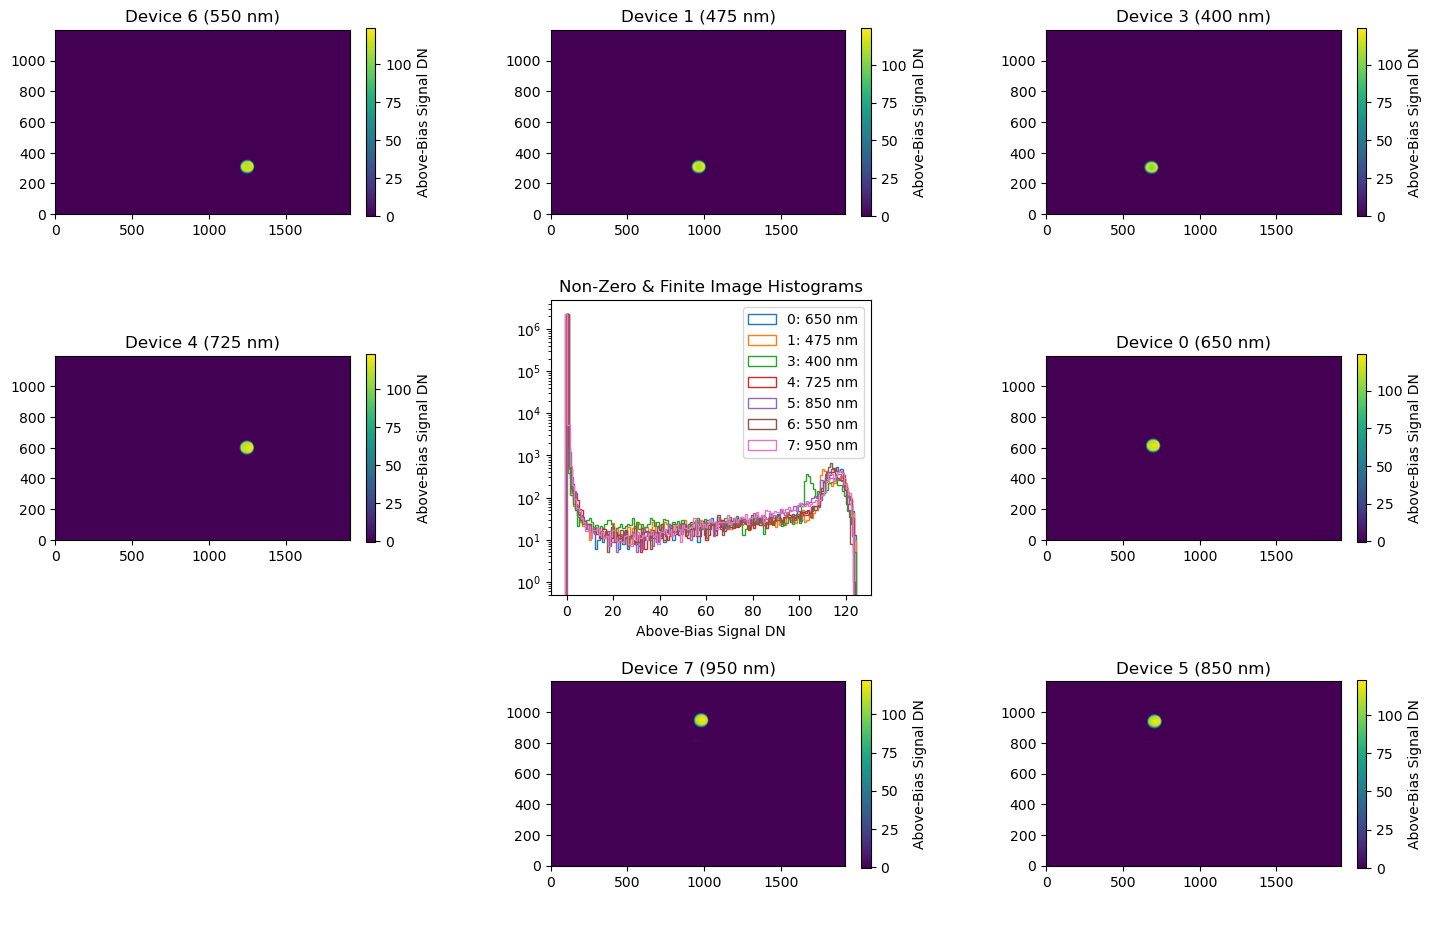

In [4]:
cali_imgs = osp.load_reflectance_calibration('reflectance_calibration')

Here we see the placement of the spectralon target in the field of each channel, and we see the histogram of each image (after dark frame subtraction).

This shows that all channels have an approximately equal distribution, with the exception of the 400 nm (device 3) channel, that has a small bimodality.

We can investigate more closely by showing each channel over the respective region of interest:

Loading Calibration Target for: 0 (650 nm)
Loading Calibration Target for: 1 (475 nm)
Loading Calibration Target for: 3 (400 nm)
Loading Calibration Target for: 4 (725 nm)
Loading Calibration Target for: 5 (850 nm)
Loading Calibration Target for: 6 (550 nm)
Loading Calibration Target for: 7 (950 nm)


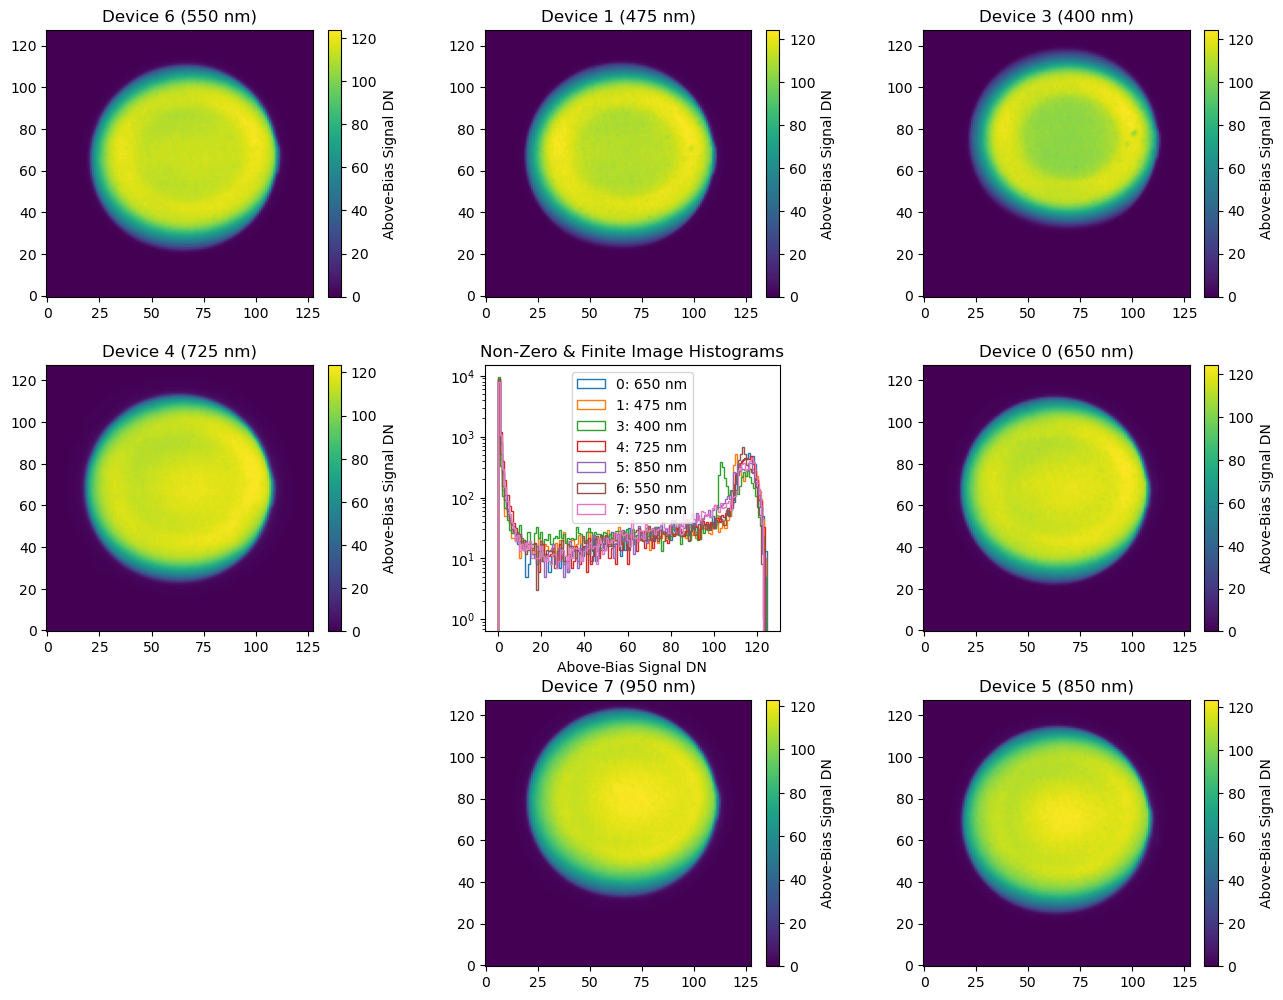

In [5]:
cali_imgs = osp.load_reflectance_calibration('reflectance_calibration', roi=True)

Indeed we see a ring structure emerge in the 400 nm channel.

This is simple to correct for with the method of finding the calibration coefficient for each individual pixel.

Note also that the pattern is low-frequency, and thus we would expect blurring of the image to preserve this nonuniformity, if it was desirable to remove high-frequency spatial nonuniformities, as may be inherent to the spectral surface reflectance.

We now find the calibration coefficients:

In [6]:
cali_coeffs = osp.calibrate_reflectance(cali_imgs, clip=0.0)

Finding Reflectance Correction for: 0 (650 nm)
Finding Reflectance Correction for: 1 (475 nm)
Finding Reflectance Correction for: 3 (400 nm)


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:360: RuntimeWarning: divide by zero encountered in divide
  self.img_stk = self.reference_reflectance / self.img_stk
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:361: RuntimeWarning: divide by zero encountered in divide
  self.img_ave = self.reference_reflectance / self.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:362: RuntimeWarning: divide by zero encountered in divide
  lght_err = self.img_std/lst_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:362: RuntimeWarning: invalid value encountered in divide
  lght_err = self.img_std/lst_ave


Finding Reflectance Correction for: 4 (725 nm)
Finding Reflectance Correction for: 5 (850 nm)
Finding Reflectance Correction for: 6 (550 nm)
Finding Reflectance Correction for: 7 (950 nm)


By considering the histograms we can see that each target has a long-tailed distribution (note the logarithmic y-axis).

This is due to darkening of the illumination at the edges of the target, that result in high reciprocals - i.e. reflectance calibration coefficients.

These bright edges are shown in the individual channel image regions of interest.

These edge regions should be avoided during sample processing.

We could enforce that at this stage by applying a mask to these image products set to discard pixels lower than the 73rd percentile.

Note that when setting to the rounder 75th percentile, we found a number of interior pixels were discarded in some channels, implying the clipping criteria was too stringent. Relaxing to the 73rd percentile retains interior pixels, but leaves a small increase at the disc edge.

Finding Reflectance Correction for: 0 (650 nm)
Exposure already corrected.
Finding Reflectance Correction for: 1 (475 nm)
Exposure already corrected.


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:360: RuntimeWarning: divide by zero encountered in divide
  self.img_stk = self.reference_reflectance / self.img_stk
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:361: RuntimeWarning: divide by zero encountered in divide
  self.img_ave = self.reference_reflectance / self.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:362: RuntimeWarning: divide by zero encountered in divide
  lght_err = self.img_std/lst_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:362: RuntimeWarning: invalid value encountered in divide
  lght_err = self.img_std/lst_ave


Finding Reflectance Correction for: 3 (400 nm)
Exposure already corrected.
Finding Reflectance Correction for: 4 (725 nm)
Exposure already corrected.
Finding Reflectance Correction for: 5 (850 nm)
Exposure already corrected.
Finding Reflectance Correction for: 6 (550 nm)
Exposure already corrected.
Finding Reflectance Correction for: 7 (950 nm)
Exposure already corrected.


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:802: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


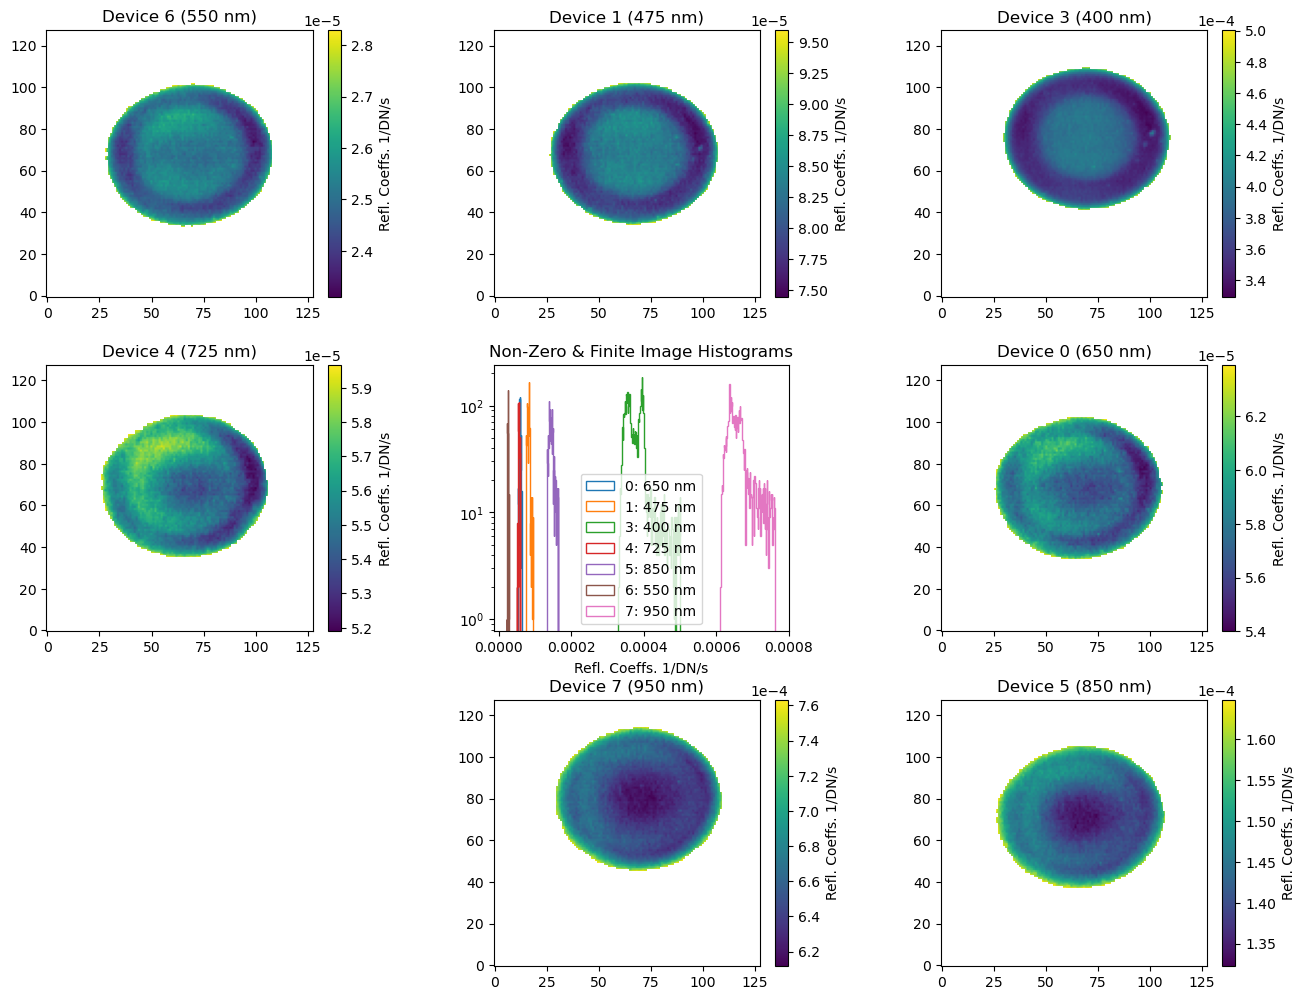

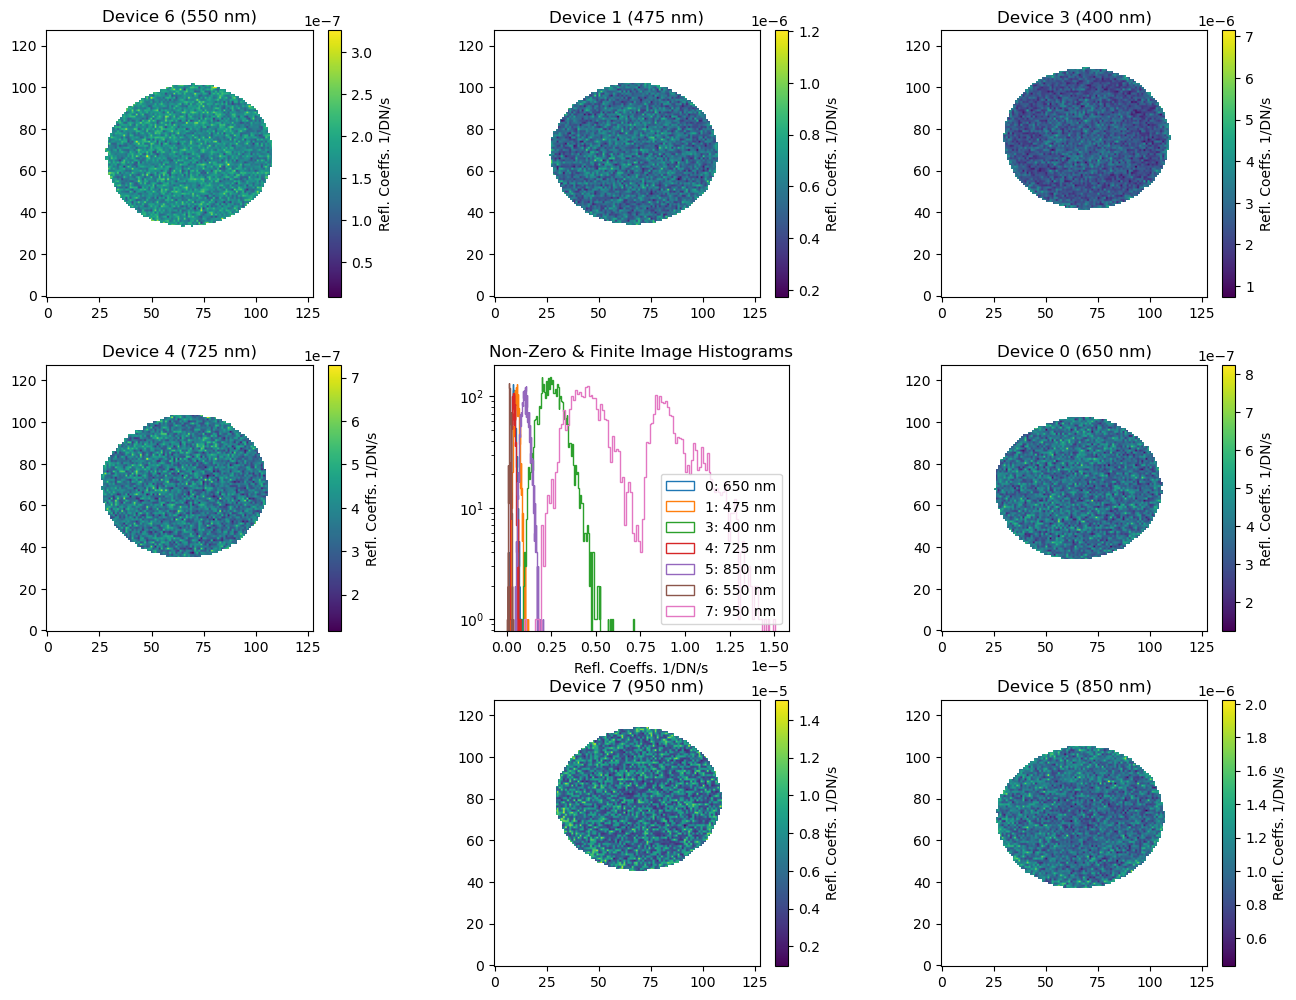

In [11]:
cali_coeffs = osp.calibrate_reflectance(cali_imgs, clip=0.73)

Now we see well defined histograms for each channel, although these mostly still exhibit a small amount of positive skew.

We also present the uncertainty propagated for each pixel, showing an approximatley uniform spatial distribution, with the exception of the 950 nm channel that appears to have a bimodal noise distribution. 

The change to this noise pattern after applying Gaussian blurring to the reflectance calibration frame will be of interest.

# Homography Calibration

Here we attempt to co-align images by finding the homography matrix between images of a checkerboard over the calibration target cap.

- Load, average and bias correct geometric images
- choose destination/base image
- for each channel, find homography matrix mapping from channel/source to base
- apply image transformation for each channel.

Load the images of the geometric calibration target, and calibrate the homography matrices.

Loading Geometric Target for: 0 (650.0 nm)
Loading Geometric Target for: 1 (475.0 nm)
Loading Geometric Target for: 3 (400.0 nm)
Loading Geometric Target for: 4 (725.0 nm)
Loading Geometric Target for: 5 (850.0 nm)
Loading Geometric Target for: 6 (550.0 nm)
Loading Geometric Target for: 7 (950.0 nm)


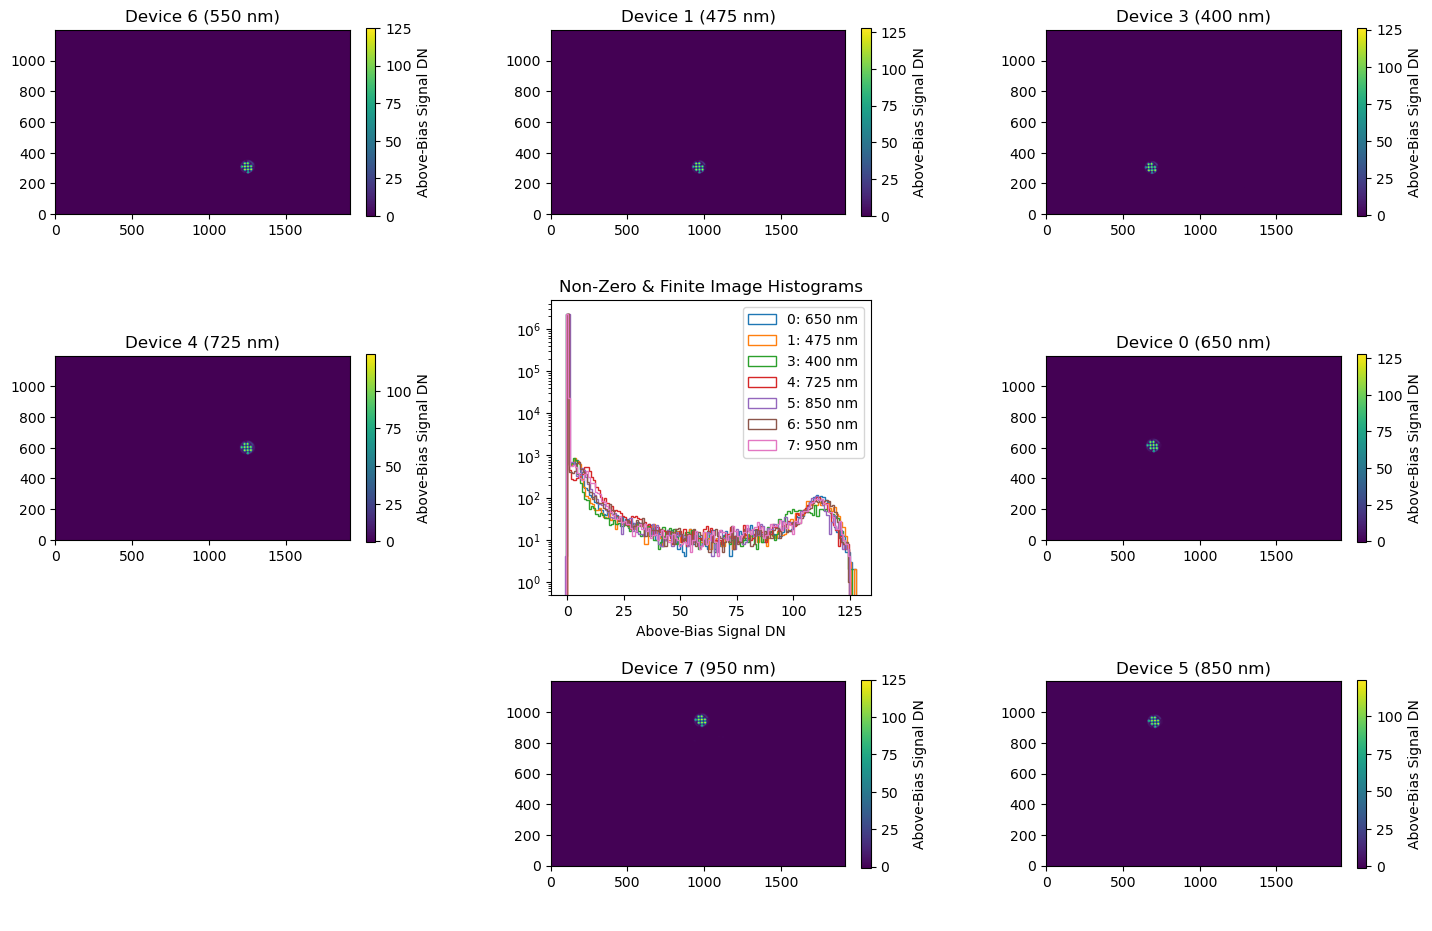

In [12]:
geocs = osp.load_geometric_calibration('geometric_calibration')

Here we see the target locations in each respective channel, illustrating the coalignment challenge.

Now we find the homoegraphy transforms from each channel to the 550 nm channel, and illustrate the transformed image error.

Calibrating Homography for: 0 (650.0 nm)
...372 source points found
...368 destination points found
...297 matches found
Calibrating Homography for: 1 (475.0 nm)
...365 source points found
...368 destination points found
...292 matches found
Calibrating Homography for: 3 (400.0 nm)
...353 source points found
...368 destination points found
...282 matches found
Calibrating Homography for: 4 (725.0 nm)


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:575: RuntimeWarning: divide by zero encountered in divide
  img = np.abs(query_reg-train_img)/train_img
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:575: RuntimeWarning: invalid value encountered in divide
  img = np.abs(query_reg-train_img)/train_img


...353 source points found
...368 destination points found
...282 matches found
Calibrating Homography for: 5 (850.0 nm)
...341 source points found
...368 destination points found
...272 matches found
Calibrating Homography for: 6 (550.0 nm)
...368 source points found
...368 destination points found
...294 matches found
Calibrating Homography for: 7 (950.0 nm)
...350 source points found
...368 destination points found
...280 matches found


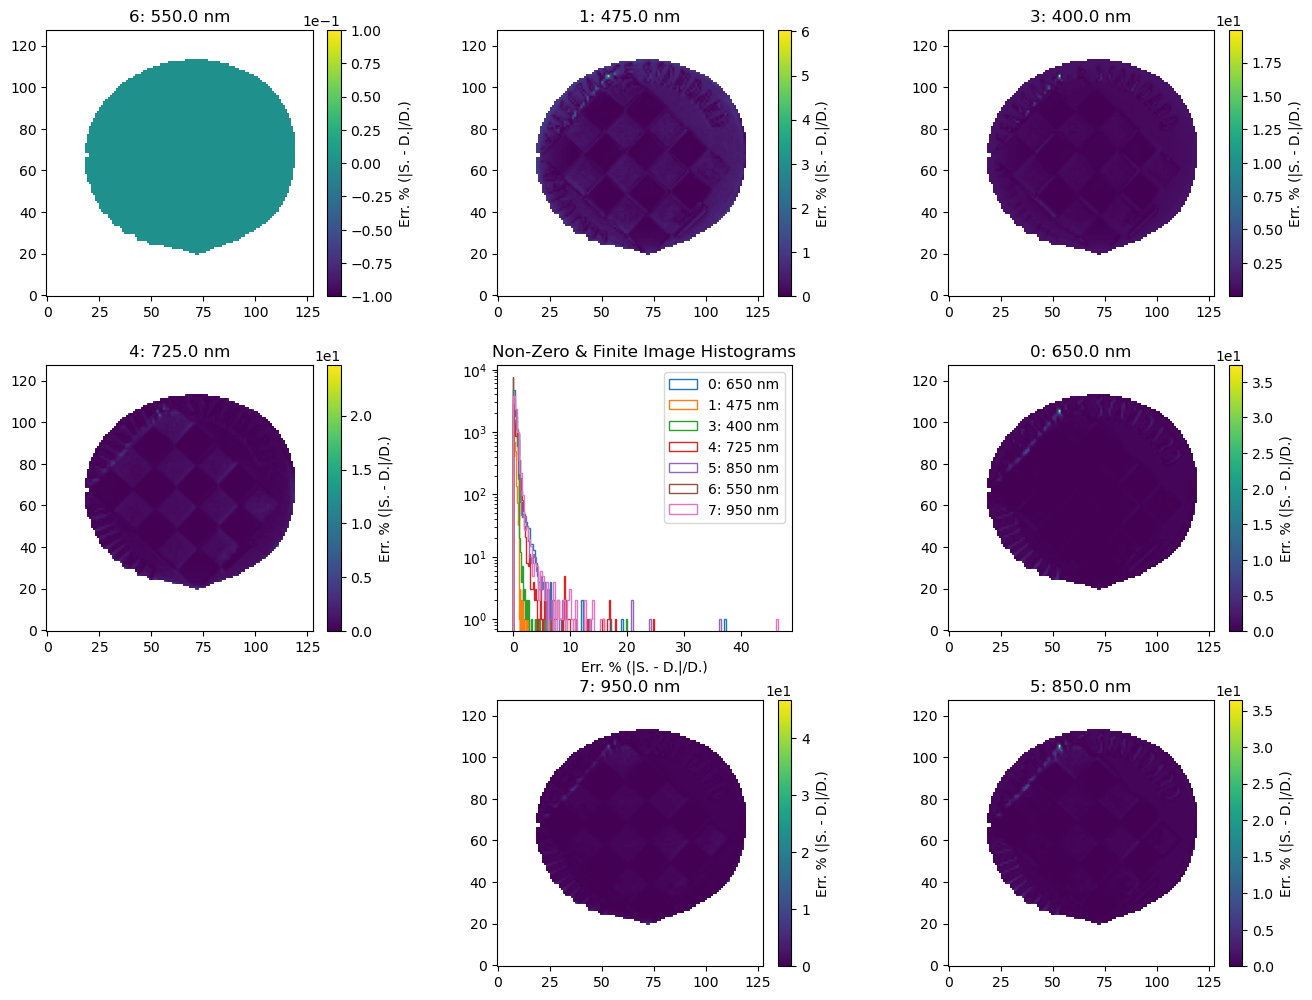

In [13]:
coals = osp.calibrate_homography(geocs)

We see that the matching generally finds a high number of match points, in the region of 280 - 300, to use for finding the homography matrix.

We can see that for all channels the majority of pixels are transformed with <=5% error, with error mostly occuring at object edges. This implies that low-frequency image detail will be preserved during transformations.

# Validation by Repeat Imaging of the Spectralon 99% Target

We now check the pipeline for reflectance calibration by processing a repeat set of images of the spectralon 99% reflectance calibration target.

Note that these images were captured after an afternoons sequence of imaging, so there is a considerable time difference between the capture of the calibration images and the validation images.

Originally this was performed on the 5% reflectance target, however therre was an issue with th dark frame exposure times for that iamge set, so here we use repeat images of the spectralon target instead. Note, the placement of the target had been radnomly reoriented on the sample area mounting plate, and so we expect spatial pattern inherent to the calibration to be amplified, rather than cancelled here.

First we load the images:

Loading reflectance_calibration_2: 0 (650 nm)
Loading reflectance_calibration_2: 1 (475 nm)
Loading reflectance_calibration_2: 3 (400 nm)
Loading reflectance_calibration_2: 4 (725 nm)
Loading reflectance_calibration_2: 5 (850 nm)
Loading reflectance_calibration_2: 6 (550 nm)
Loading reflectance_calibration_2: 7 (950 nm)


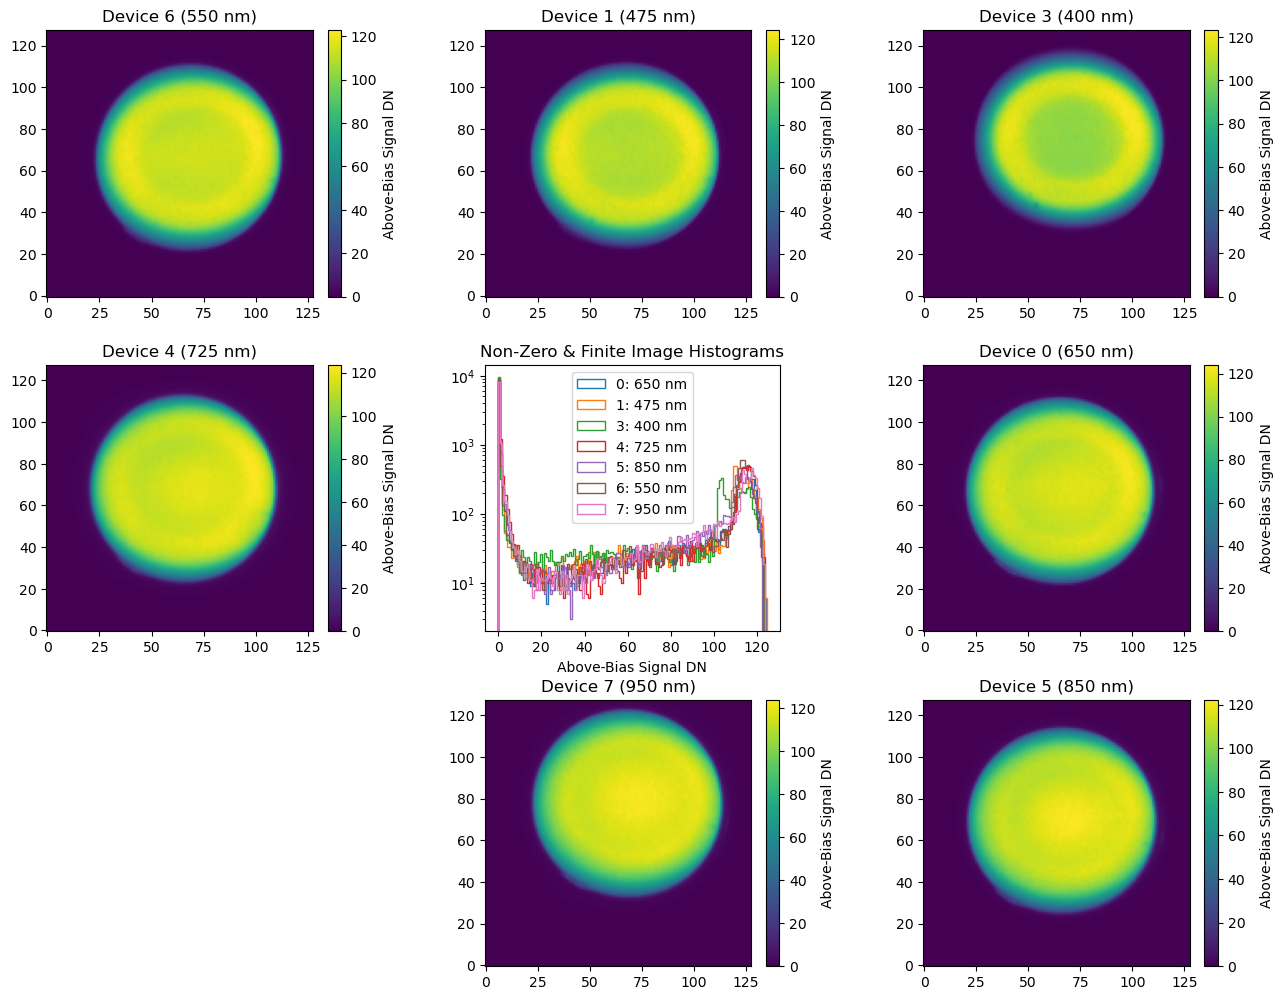

In [23]:
smpl_imgs = osp.load_sample('reflectance_calibration_2', roi=True)

We see that the images appear very similar to those captured in the first round during calibration.

Exposure already corrected.
../data/reflectance_calibration_2/0_650
Mean image written to ../data/reflectance_calibration_2/0_650/650_mean_rfl.tif
Error image written to ../data/reflectance_calibration_2/0_650/650_error_rfl.tif
Exposure already corrected.
../data/reflectance_calibration_2/1_475
Mean image written to ../data/reflectance_calibration_2/1_475/475_mean_rfl.tif
Error image written to ../data/reflectance_calibration_2/1_475/475_error_rfl.tif
Exposure already corrected.


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:399: RuntimeWarning: invalid value encountered in multiply
  self.img_ave = self.img_ave * cali_source.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:401: RuntimeWarning: invalid value encountered in divide
  lght_err = self.img_std/lst_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:402: RuntimeWarning: invalid value encountered in divide
  cali_err = cali_source.img_std/cali_source.img_ave


../data/reflectance_calibration_2/3_400
Mean image written to ../data/reflectance_calibration_2/3_400/400_mean_rfl.tif
Error image written to ../data/reflectance_calibration_2/3_400/400_error_rfl.tif
Exposure already corrected.
../data/reflectance_calibration_2/4_725
Mean image written to ../data/reflectance_calibration_2/4_725/725_mean_rfl.tif
Error image written to ../data/reflectance_calibration_2/4_725/725_error_rfl.tif
Exposure already corrected.
../data/reflectance_calibration_2/5_850
Mean image written to ../data/reflectance_calibration_2/5_850/850_mean_rfl.tif
Error image written to ../data/reflectance_calibration_2/5_850/850_error_rfl.tif
Exposure already corrected.
../data/reflectance_calibration_2/6_550
Mean image written to ../data/reflectance_calibration_2/6_550/550_mean_rfl.tif
Error image written to ../data/reflectance_calibration_2/6_550/550_error_rfl.tif
Exposure already corrected.
../data/reflectance_calibration_2/7_950
Mean image written to ../data/reflectance_calibr

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:802: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


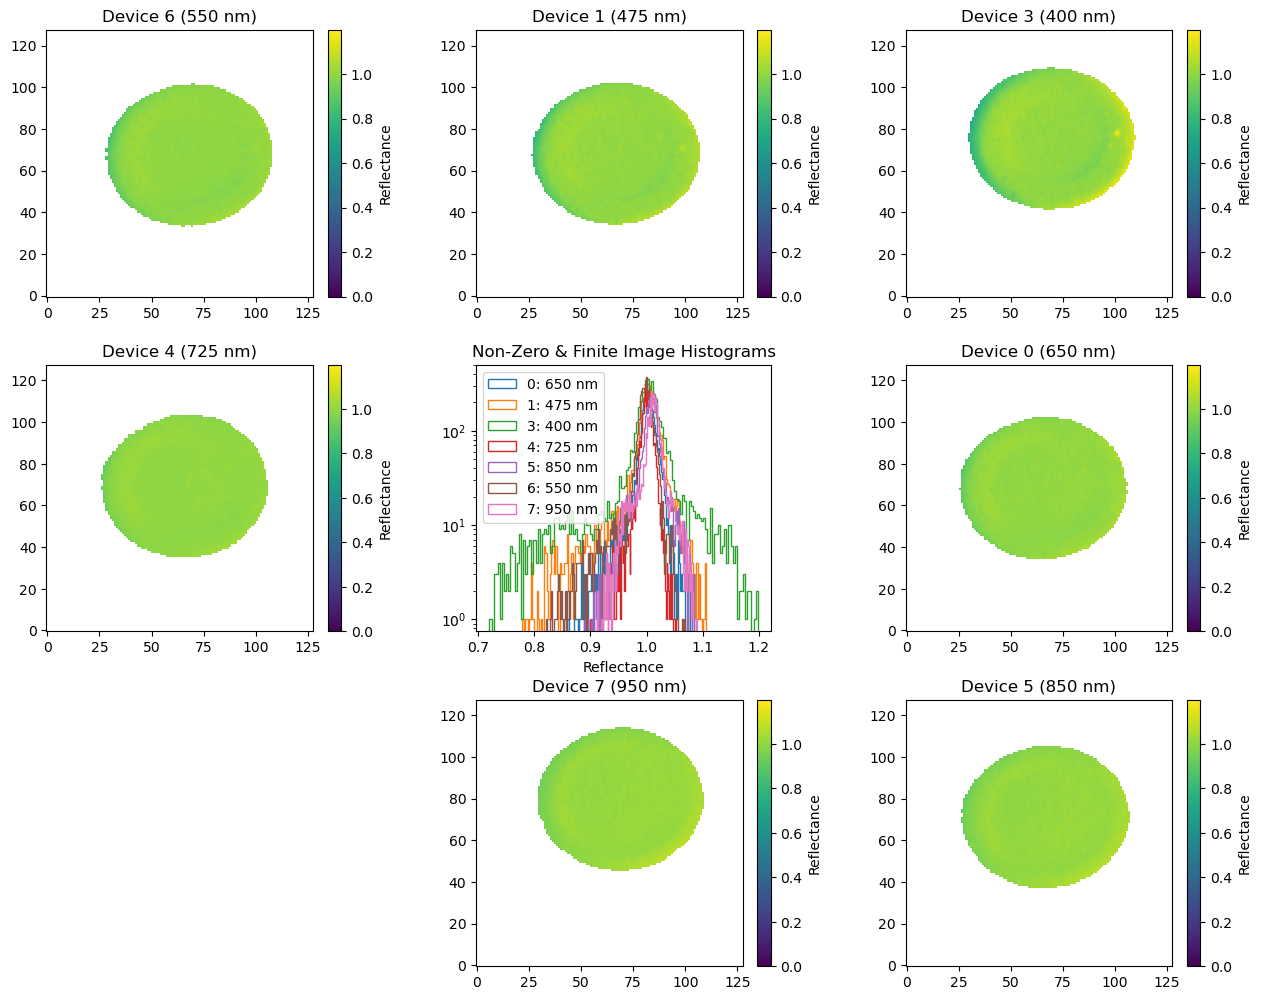

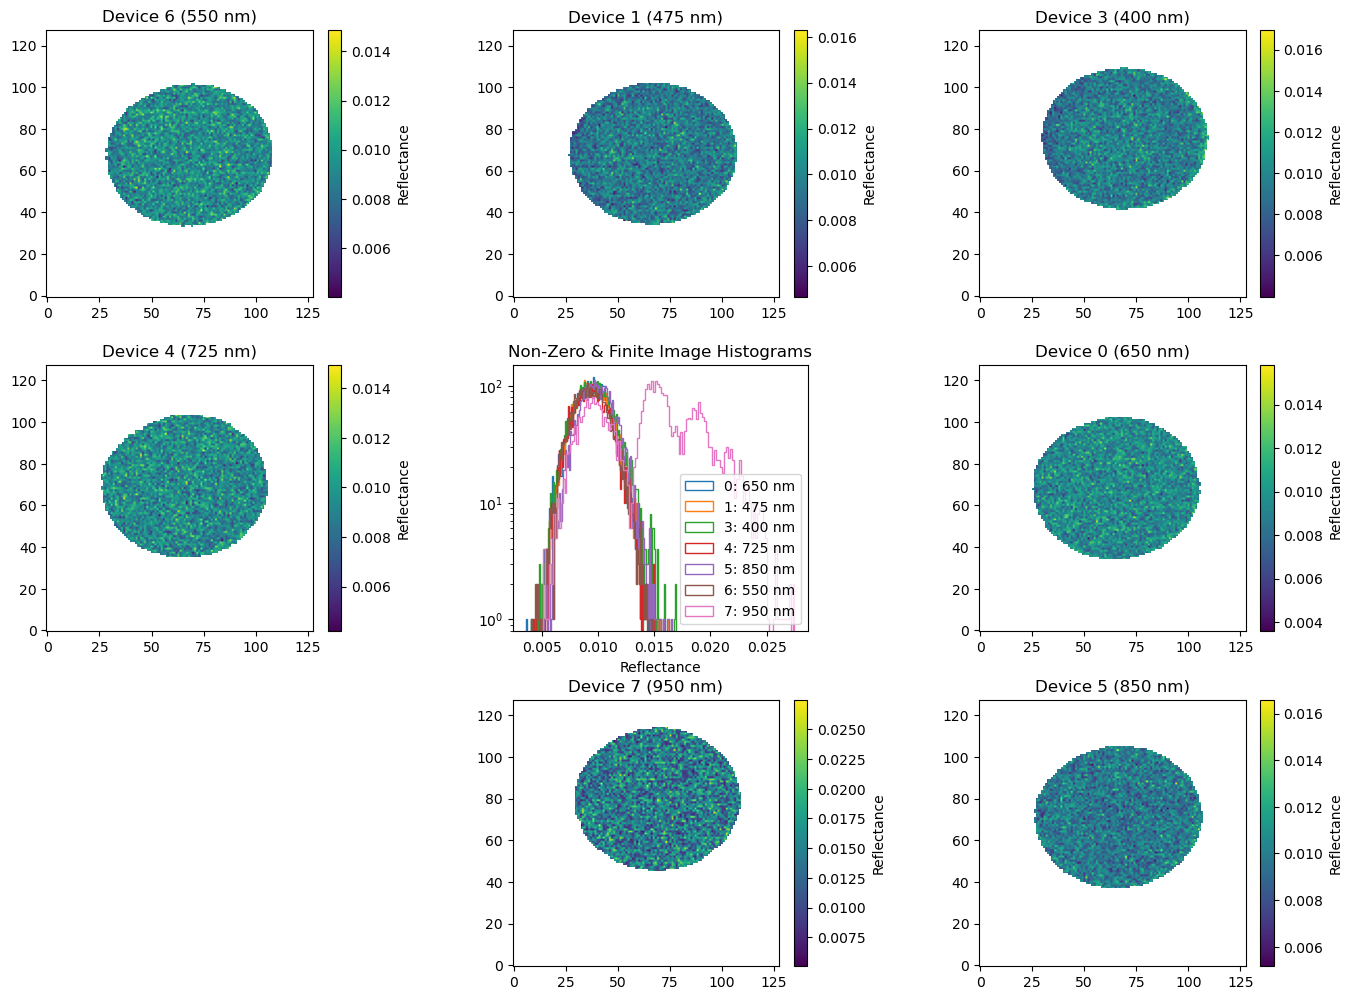

In [26]:
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

After reflectance calibration, we see that each channel has a similar well defined peak value, with approximately Gaussian distruted values above and below this.

We also see that there is a very similar uncertainty distribution for each channel, and that again the 950 nm has a bimodal distribution.

This may be due to contributions of noise from the dark signal, as we expect the 950 nm to require a longer exposure.

Lets investigate the dark frames:

Loading reflectance_calibration_2: 0 (650 nm)
Loading reflectance_calibration_2: 1 (475 nm)
Loading reflectance_calibration_2: 3 (400 nm)
Loading reflectance_calibration_2: 4 (725 nm)
Loading reflectance_calibration_2: 5 (850 nm)
Loading reflectance_calibration_2: 6 (550 nm)
Loading reflectance_calibration_2: 7 (950 nm)


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:802: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'0_650': <orochi_sim_proc.DarkImage at 0x16a13c040>,
 '1_475': <orochi_sim_proc.DarkImage at 0x14f453040>,
 '3_400': <orochi_sim_proc.DarkImage at 0x1535abe50>,
 '4_725': <orochi_sim_proc.DarkImage at 0x1535aa080>,
 '5_850': <orochi_sim_proc.DarkImage at 0x1535a8250>,
 '6_550': <orochi_sim_proc.DarkImage at 0x1535a8280>,
 '7_950': <orochi_sim_proc.DarkImage at 0x15d5a1180>}

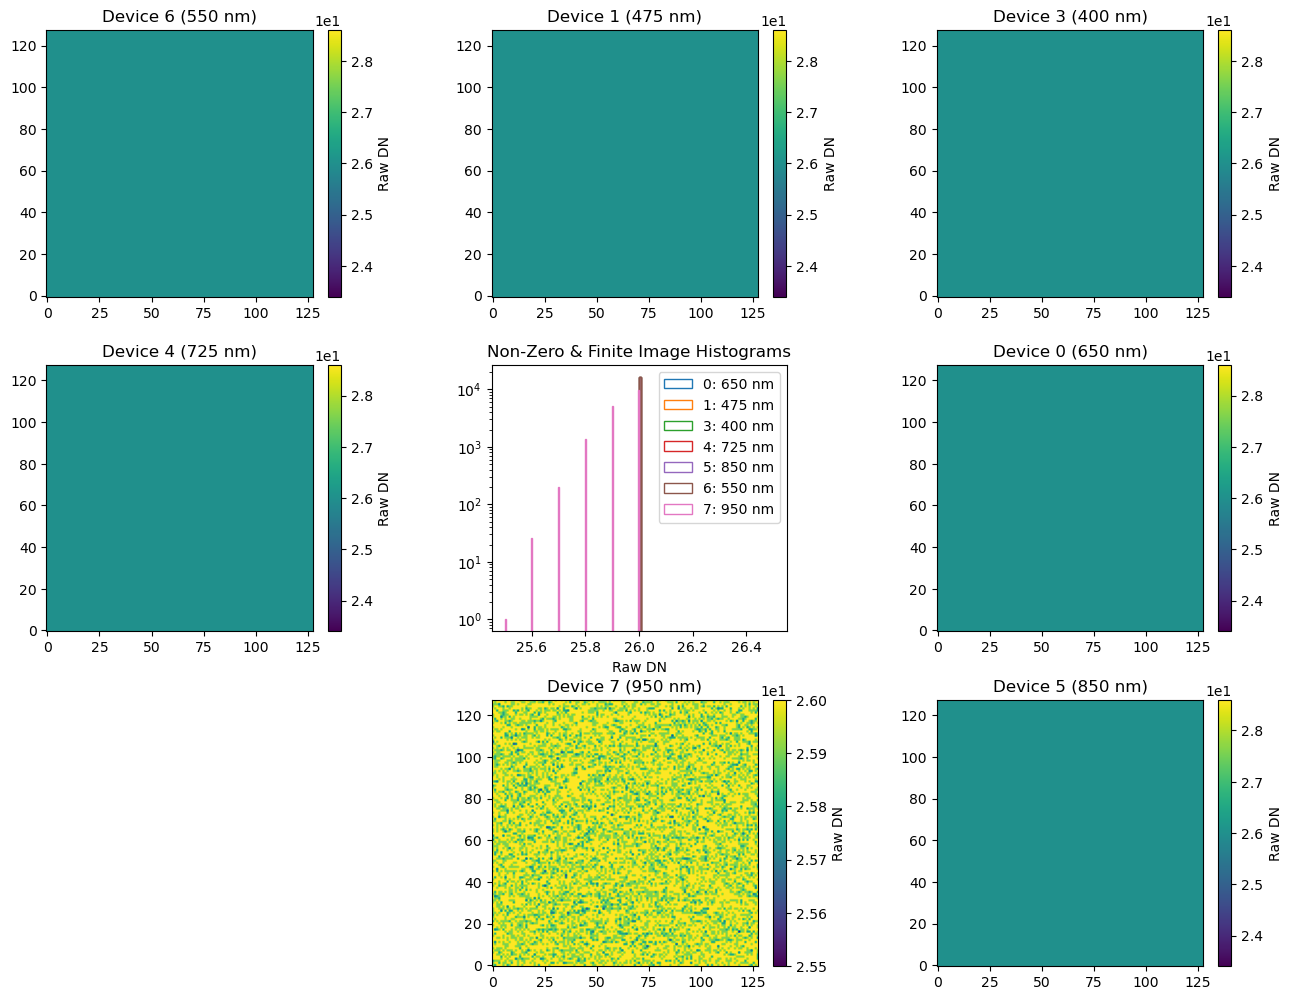

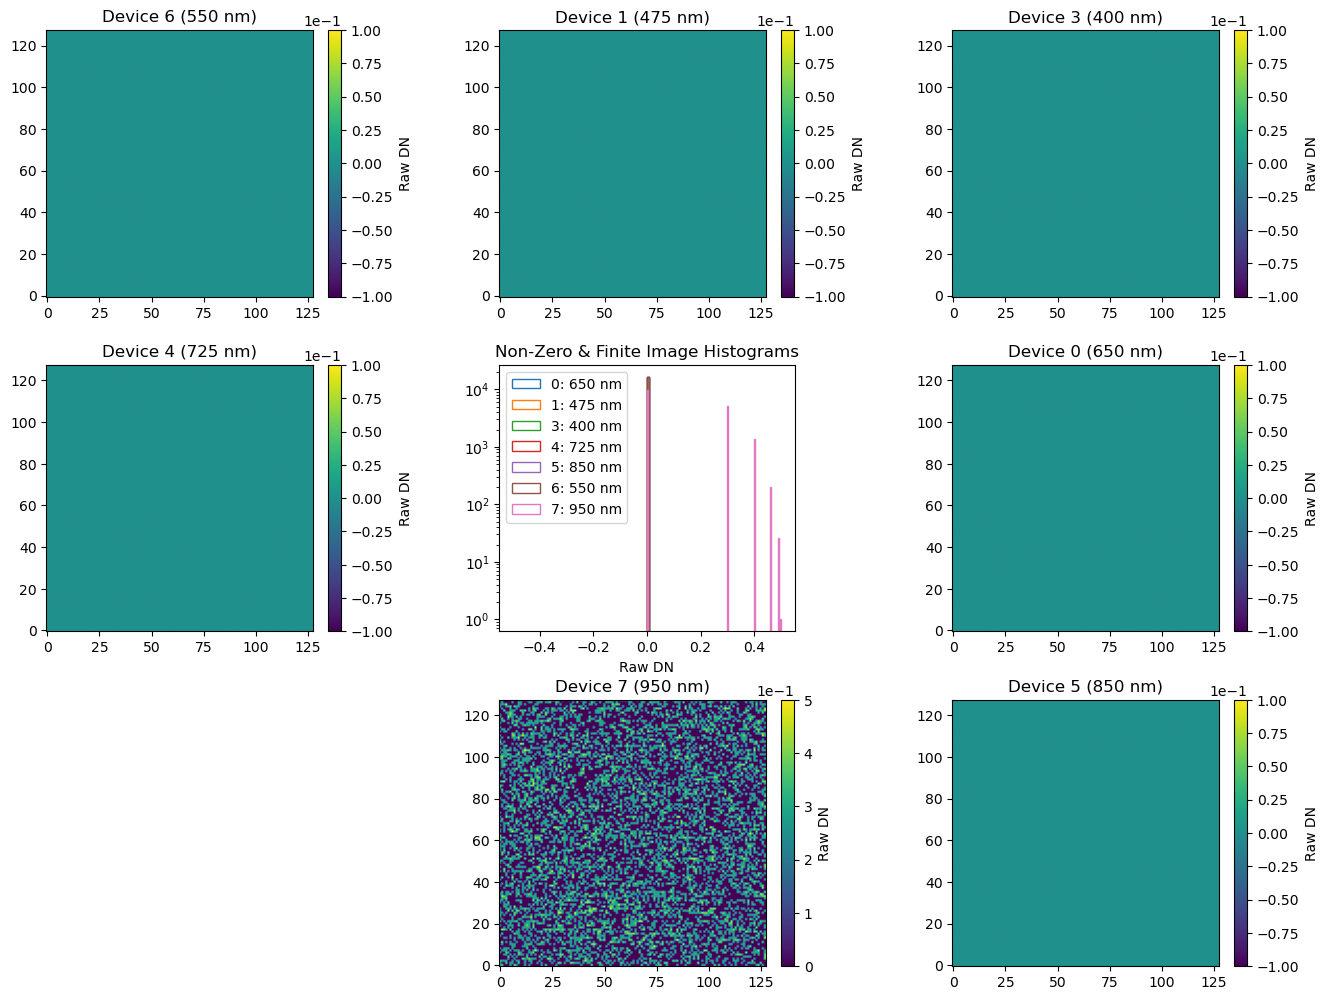

In [27]:
osp.load_dark_frames('reflectance_calibration_2', roi=True)

Indeed we find that the 950 nm channel alone exhibits non-zero dark signal nonuniformity, due to the longer exposure time.

This has a deeper implication - that the video offset is not sufficient to raise the dark signal above the camera floor - rather it appears that once a threshold exposure time is reached, only then will the dark signal reveal itself.

However, for the time being we accept this increase in noise, and continue to process the reflectance.

Next we attempt image coalignment:

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:568: RuntimeWarning: invalid value encountered in subtract
  img = query_reg-train_img
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:575: RuntimeWarning: invalid value encountered in subtract
  img = np.abs(query_reg-train_img)/train_img
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:575: RuntimeWarning: invalid value encountered in divide
  img = np.abs(query_reg-train_img)/train_img


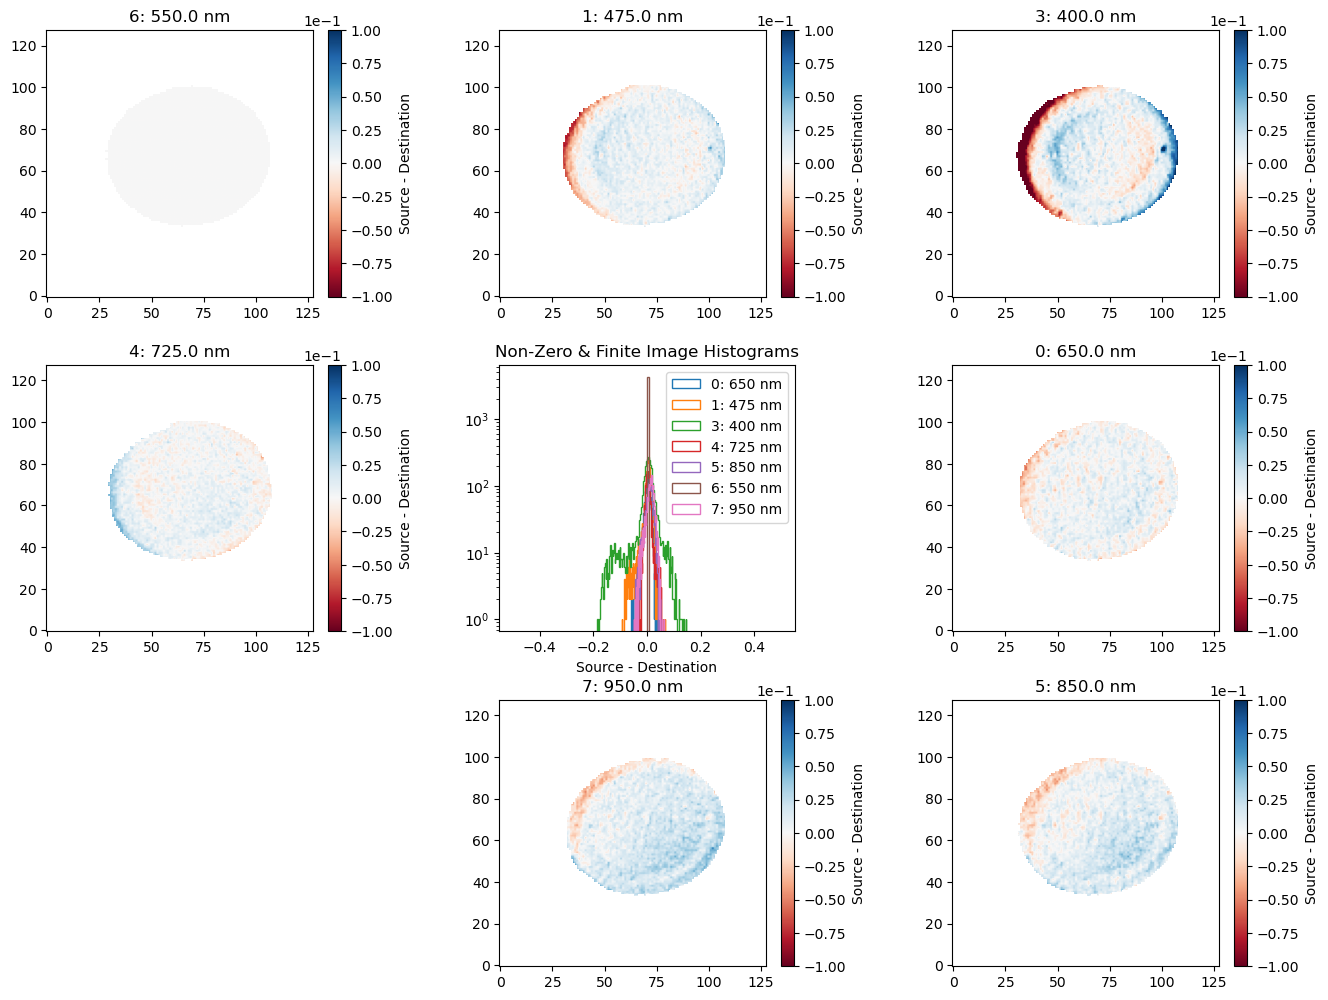

In [28]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

Here we see that there is very low coalignment error, as anticipated for an approximately spatially uniform target.

However, we do see the imprint of the spatial pattern of the illumination over the sample area. This simply implies that the pattern may change from channel to channel, which is indeed what we oberseved when first loading in the target images (recall ring structure in the 400 nm channel).

We now plot the reflectance of a manually selected Region of Interest:

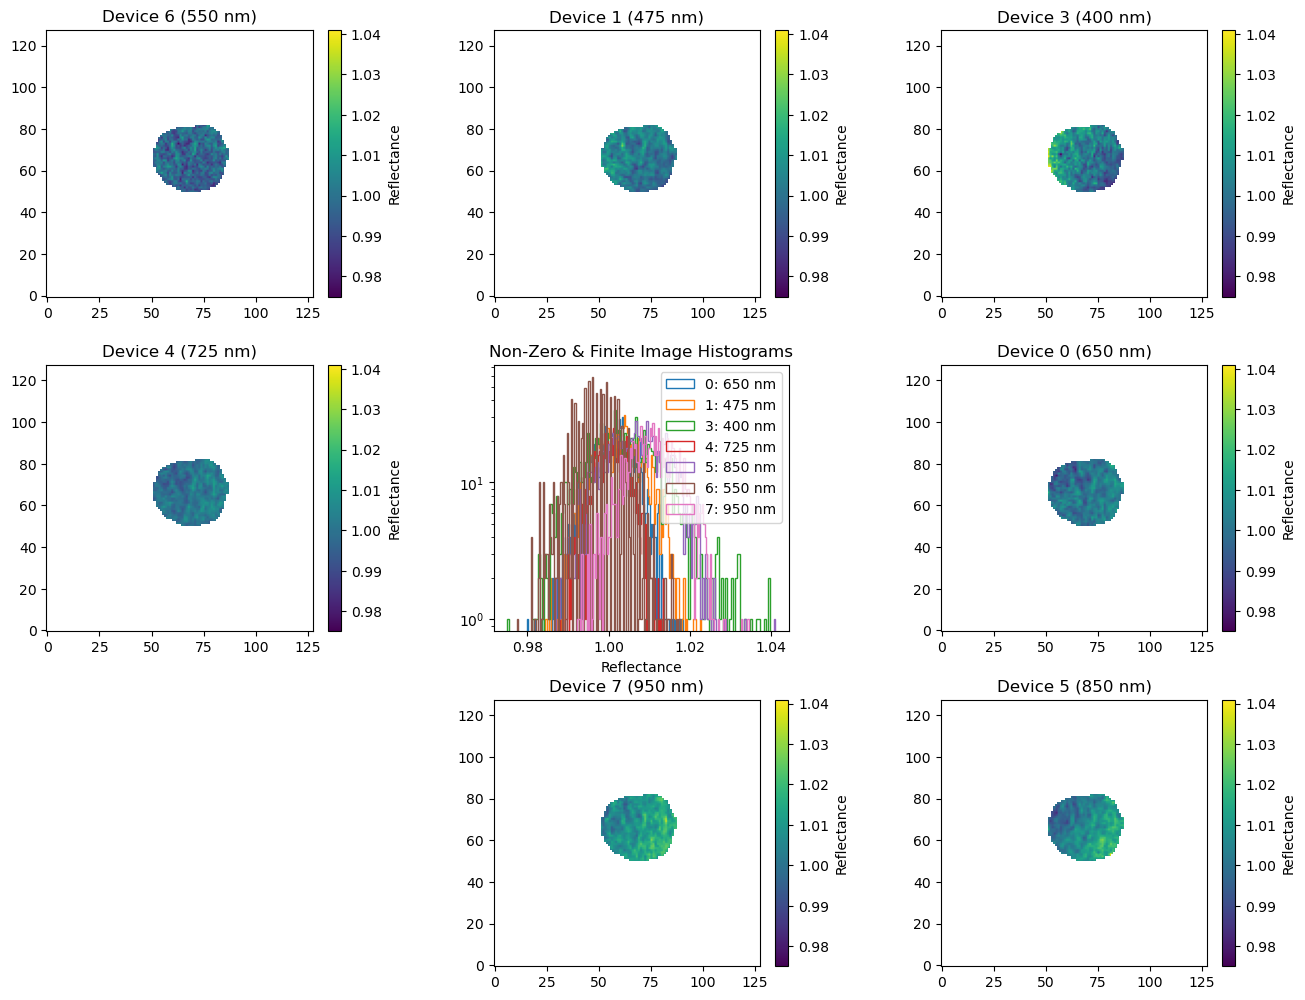

In [29]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

Now we plot these results, in comparison to the expectation, that we retrieve:

In [60]:
reference_reflectance = osp.get_reference_reflectance(cali_coeffs)

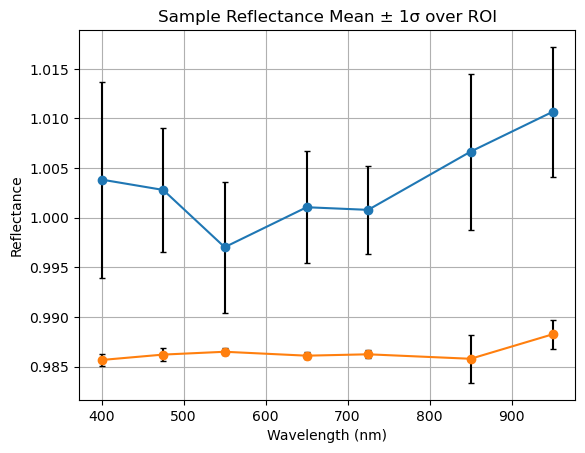

In [62]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois, reference_reflectance=reference_reflectance)

We actually find that there is a significant (greater than the error bars) offset between the observed values and the expected reflectance values.

This is still less than 3% error. However, we would expect this to be a closer value.

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:408: RuntimeWarning: invalid value encountered in divide
  self.img_ave = self.img_ave / base.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:802: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


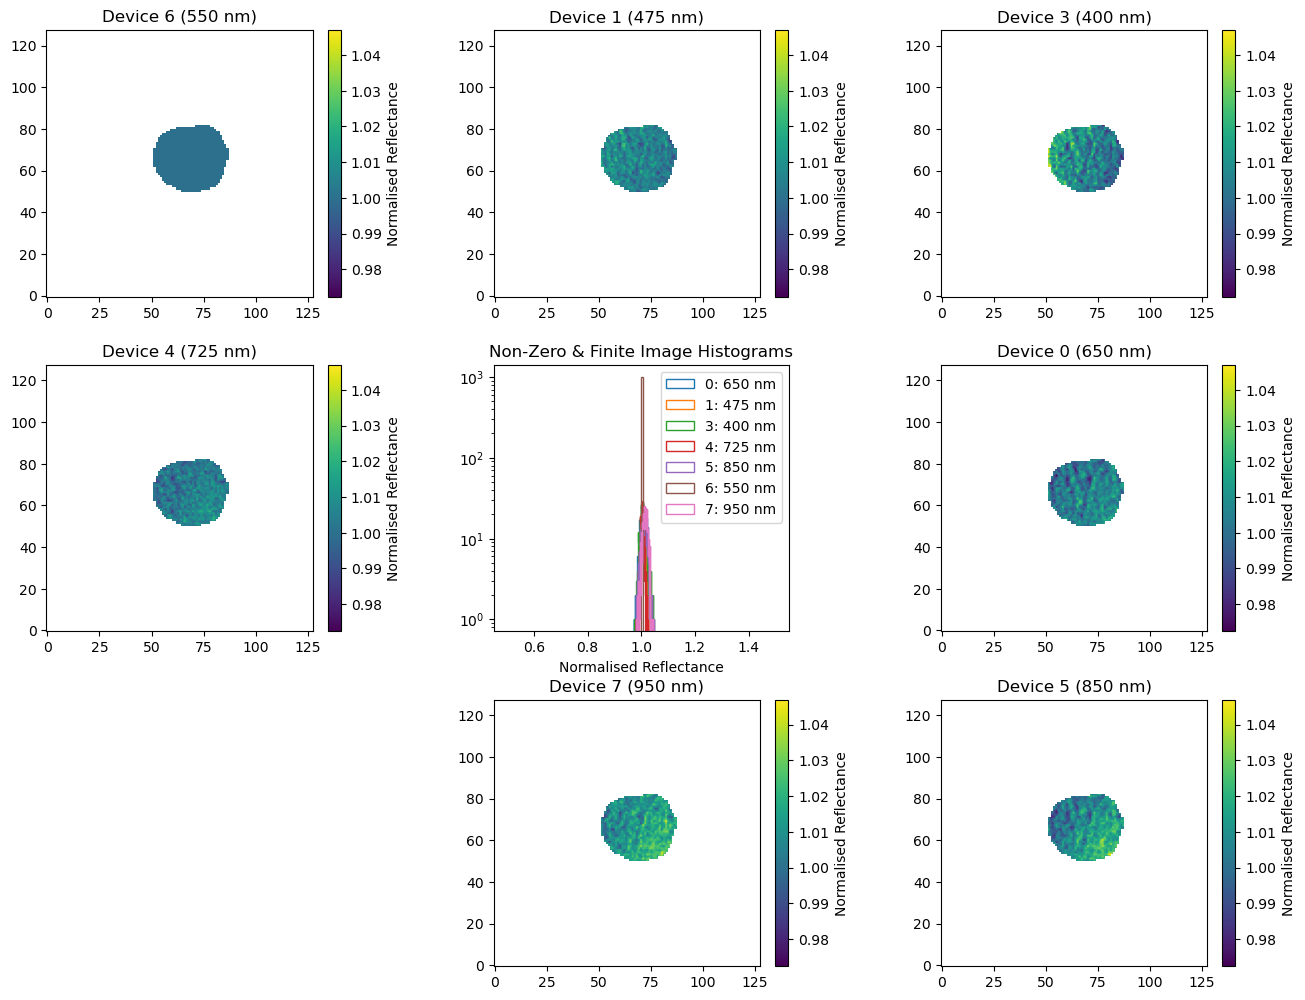

In [65]:
norm_refl = osp.normalise_reflectance(aligned_refl)

Normalisng the reference reflectance:

In [69]:
reference_reflectance.reference = reference_reflectance.reference / reference_reflectance.reference['6_550']

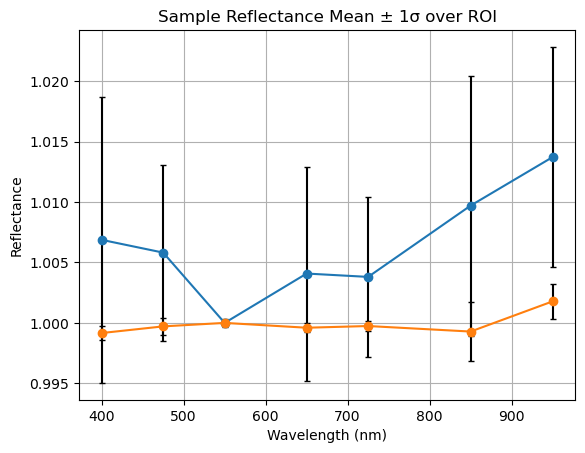

In [70]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl, reference_reflectance=reference_reflectance)

In conclusion, we can see that there is some discrepency between the observed and expected reflectance values, that we should investigate the cause of.

The first investigation will be to simply recollect the data, by first collecting calibration images, and then immediately collecting a second set, with the target reoriented, and then collecting tertiary sets to accompany each instance of imaging, as 'witness' plates.

# Sample Reflectance Calibration and Coalignment

In this section we apply both the reflectance calibration and image co-alignment to our samples images.
First we load our sample images, for both right and left illumination incidence angles.

The steps are:
- Load, average and bias correct Sample images
- Correct for exposure
- Apply calibration coefficient frames
- Optional: mask for Calibration Target area and Sample area.
- Save reflectance images

# Right and Left Samples

Now we will process the images of the rock samples.

5 samples have been imaged, under illumination with incidence angles of + and - 30°.

# Sample 1

## Left

### Reflectance Calibration

We load in the sample images, and immediately apply the reflectance correction.

Loading sample_1_r: 0 (650 nm)
Loading sample_1_r: 1 (475 nm)
Loading sample_1_r: 3 (400 nm)
Loading sample_1_r: 4 (725 nm)
Loading sample_1_r: 5 (850 nm)
Loading sample_1_r: 6 (550 nm)
Loading sample_1_r: 7 (950 nm)


/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:805: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  channels = sorted(list(Path('..', 'data', subject).glob('[!.]*')))


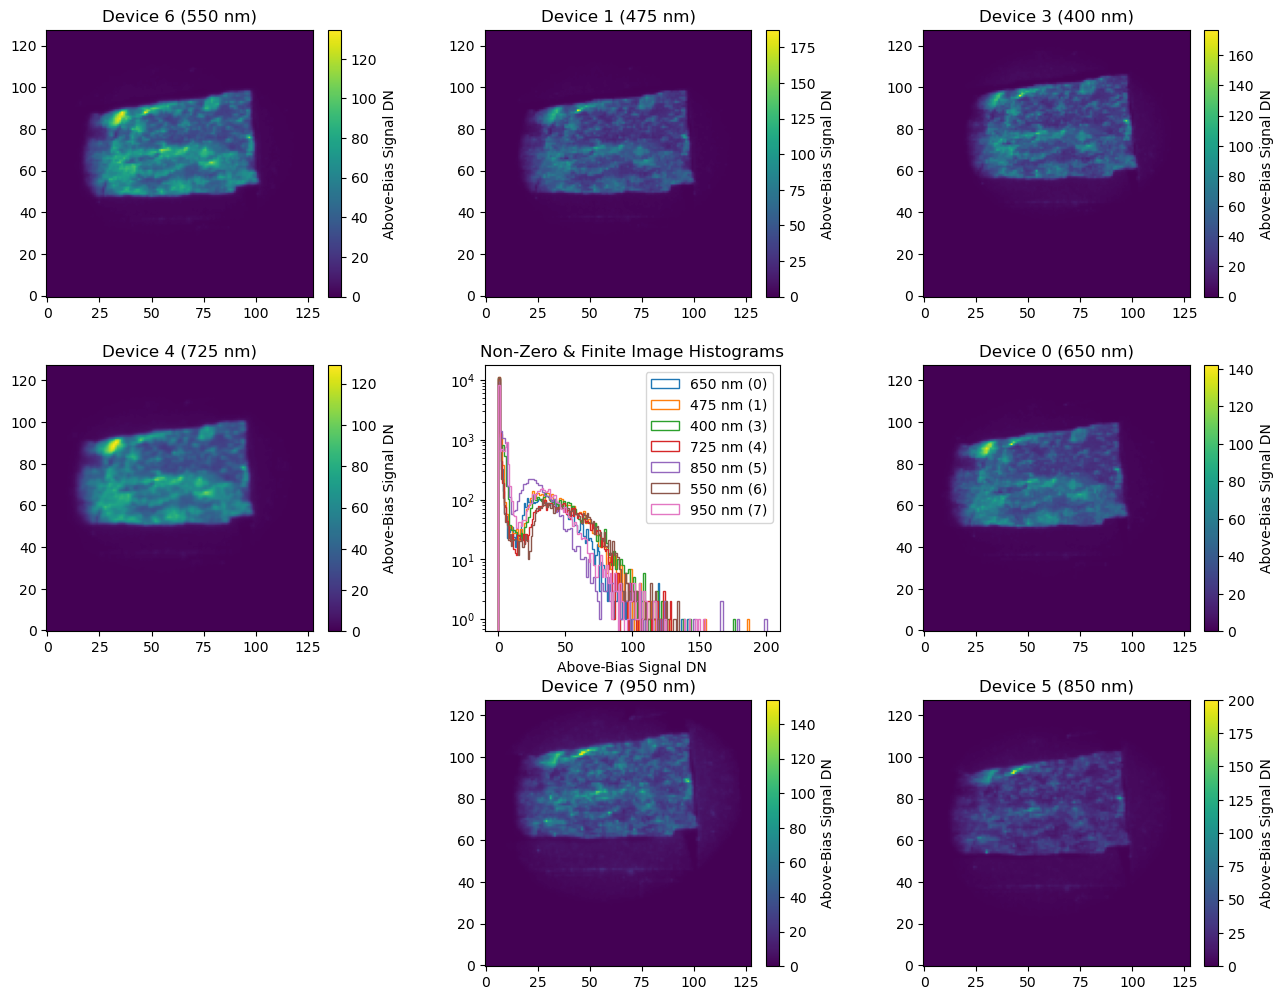

In [83]:
smpl_imgs = osp.load_sample('sample_1_r', roi=True)

We can see that the channels are mostly in focus, and that there exist some bright regions that approximately correlate across all channels.

NOw we apply the reflectance calibration:

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:401: RuntimeWarning: invalid value encountered in multiply
  lght_err = self.img_std/lst_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:403: RuntimeWarning: invalid value encountered in divide
  self.img_std = self.img_ave * np.sqrt((lght_err)**2 + (cali_err)**2)
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:404: RuntimeWarning: invalid value encountered in divide
  


../data/sample_1_r/0_650
Mean image written to ../data/sample_1_r/0_650/650_mean_rfl.tif
Error image written to ../data/sample_1_r/0_650/650_error_rfl.tif
../data/sample_1_r/1_475
Mean image written to ../data/sample_1_r/1_475/475_mean_rfl.tif
Error image written to ../data/sample_1_r/1_475/475_error_rfl.tif
../data/sample_1_r/3_400
Mean image written to ../data/sample_1_r/3_400/400_mean_rfl.tif
Error image written to ../data/sample_1_r/3_400/400_error_rfl.tif
../data/sample_1_r/4_725
Mean image written to ../data/sample_1_r/4_725/725_mean_rfl.tif
Error image written to ../data/sample_1_r/4_725/725_error_rfl.tif
../data/sample_1_r/5_850
Mean image written to ../data/sample_1_r/5_850/850_mean_rfl.tif
Error image written to ../data/sample_1_r/5_850/850_error_rfl.tif
../data/sample_1_r/6_550
Mean image written to ../data/sample_1_r/6_550/550_mean_rfl.tif
Error image written to ../data/sample_1_r/6_550/550_error_rfl.tif
../data/sample_1_r/7_950
Mean image written to ../data/sample_1_r/7_95

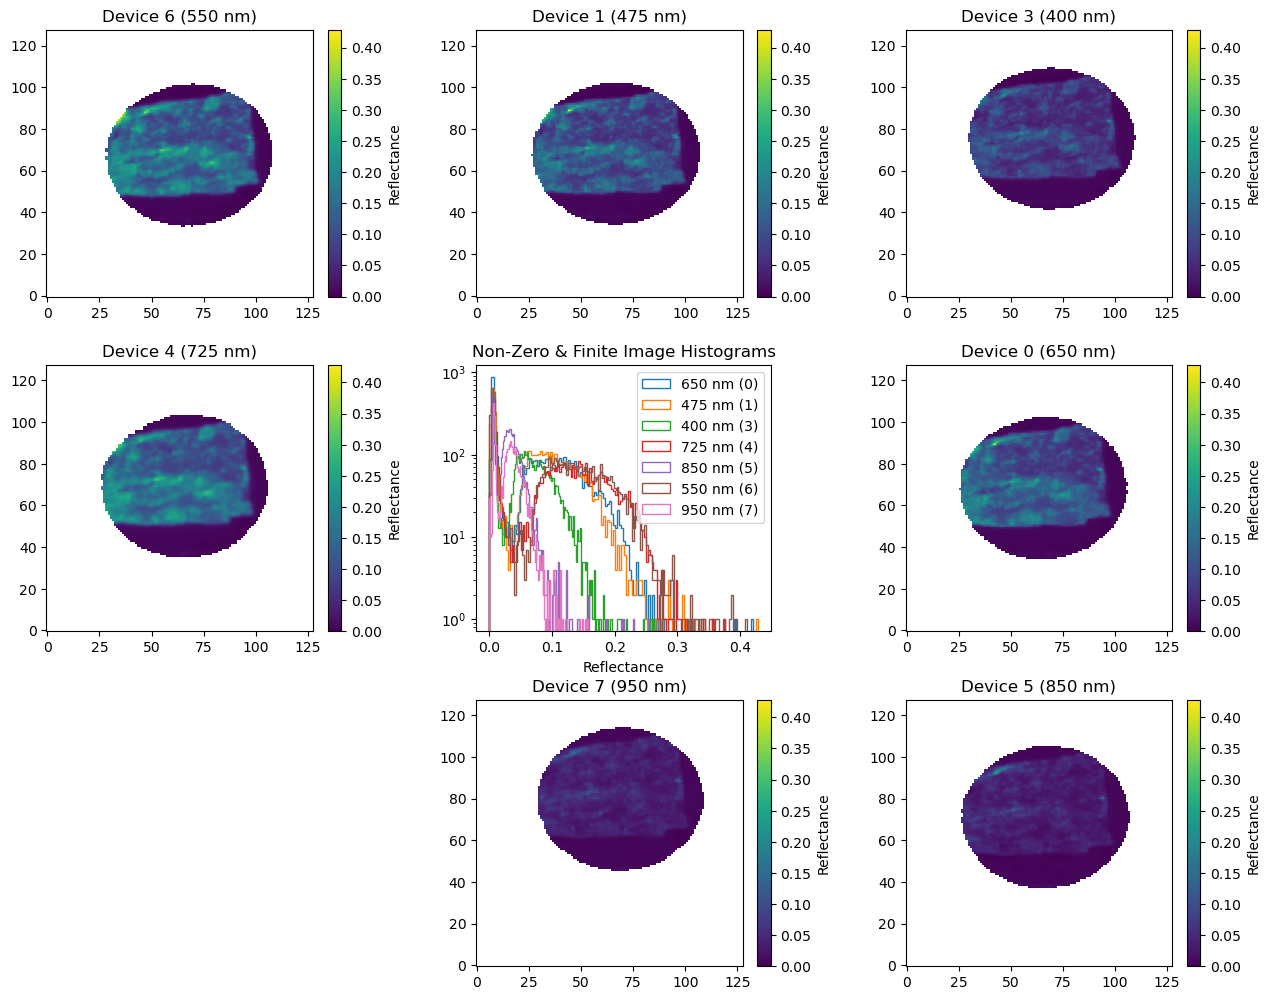

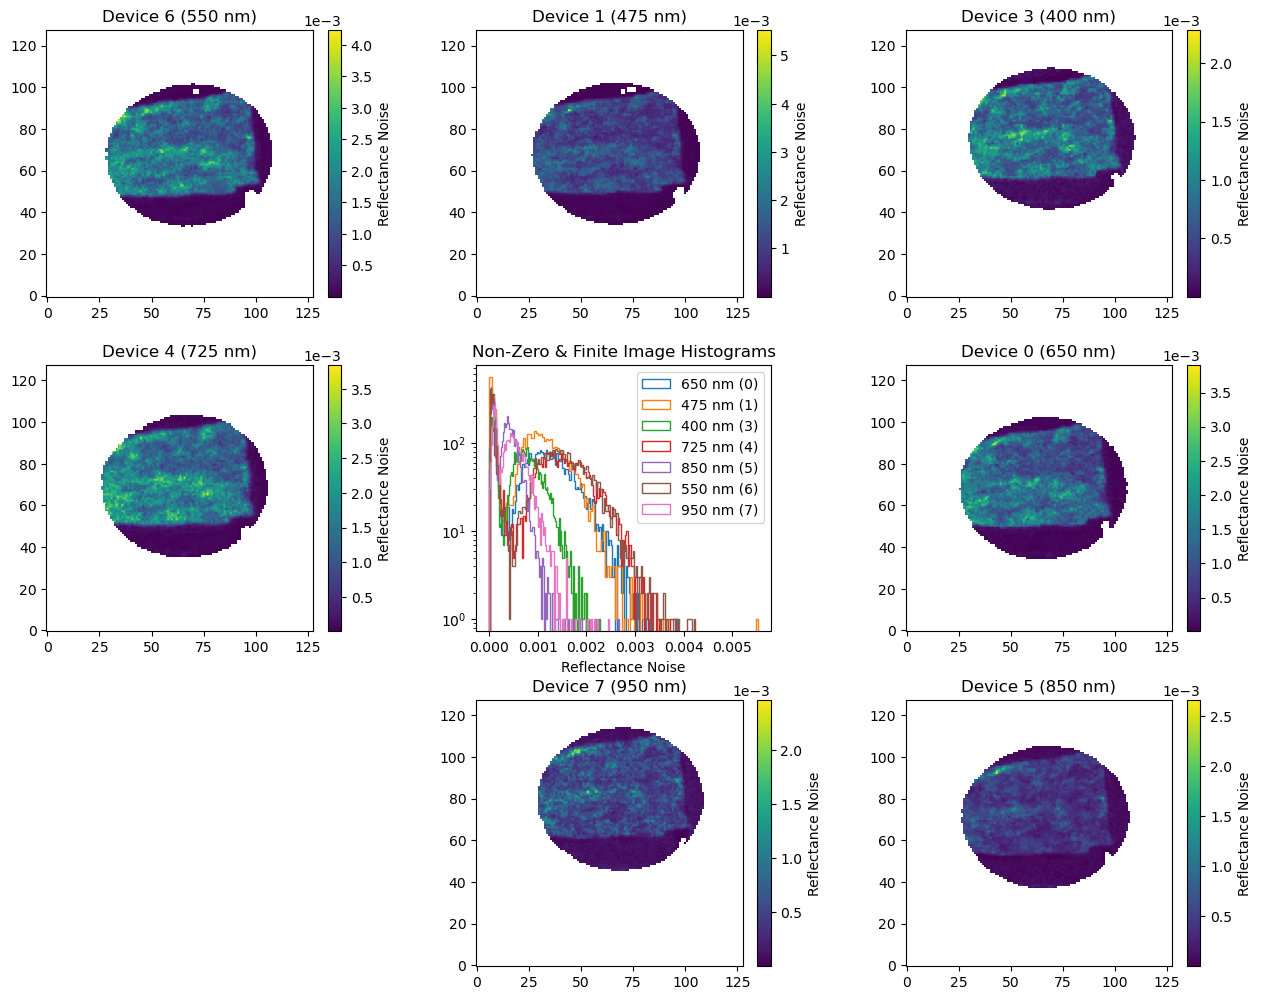

In [84]:
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

Loading sample_1_r: 0 (650 nm)
Loading sample_1_r: 1 (475 nm)
Loading sample_1_r: 3 (400 nm)
Loading sample_1_r: 4 (725 nm)
Loading sample_1_r: 5 (850 nm)
Loading sample_1_r: 6 (550 nm)
Loading sample_1_r: 7 (950 nm)


{'0_650': <orochi_sim_proc.DarkImage at 0x15d97bd60>,
 '1_475': <orochi_sim_proc.DarkImage at 0x3df650250>,
 '3_400': <orochi_sim_proc.DarkImage at 0x3da9f09d0>,
 '4_725': <orochi_sim_proc.DarkImage at 0x2e372cc40>,
 '5_850': <orochi_sim_proc.DarkImage at 0x2e372dea0>,
 '6_550': <orochi_sim_proc.DarkImage at 0x2e372f3a0>,
 '7_950': <orochi_sim_proc.DarkImage at 0x2e382ee30>}

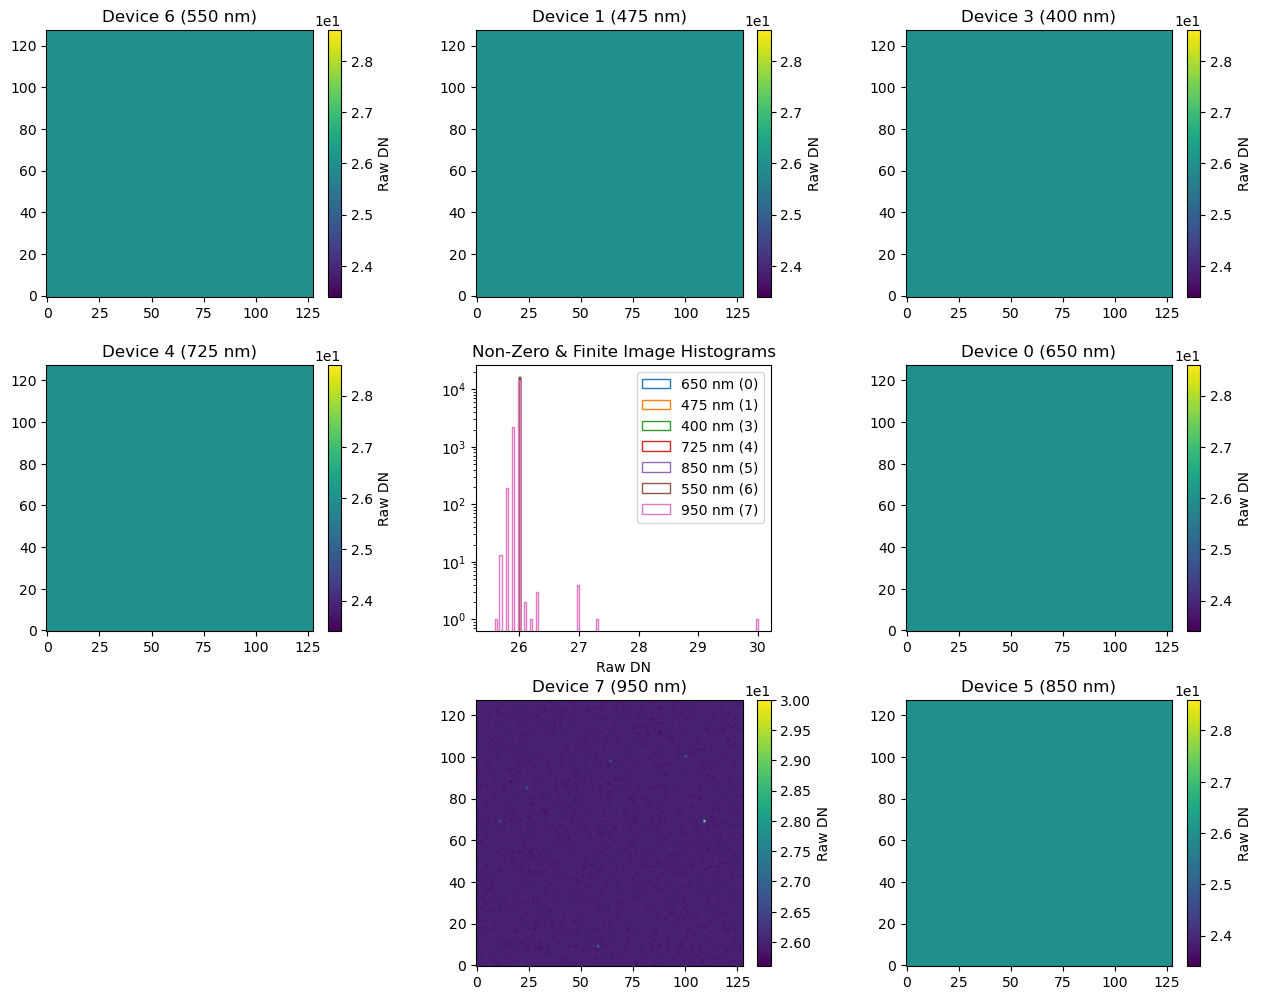

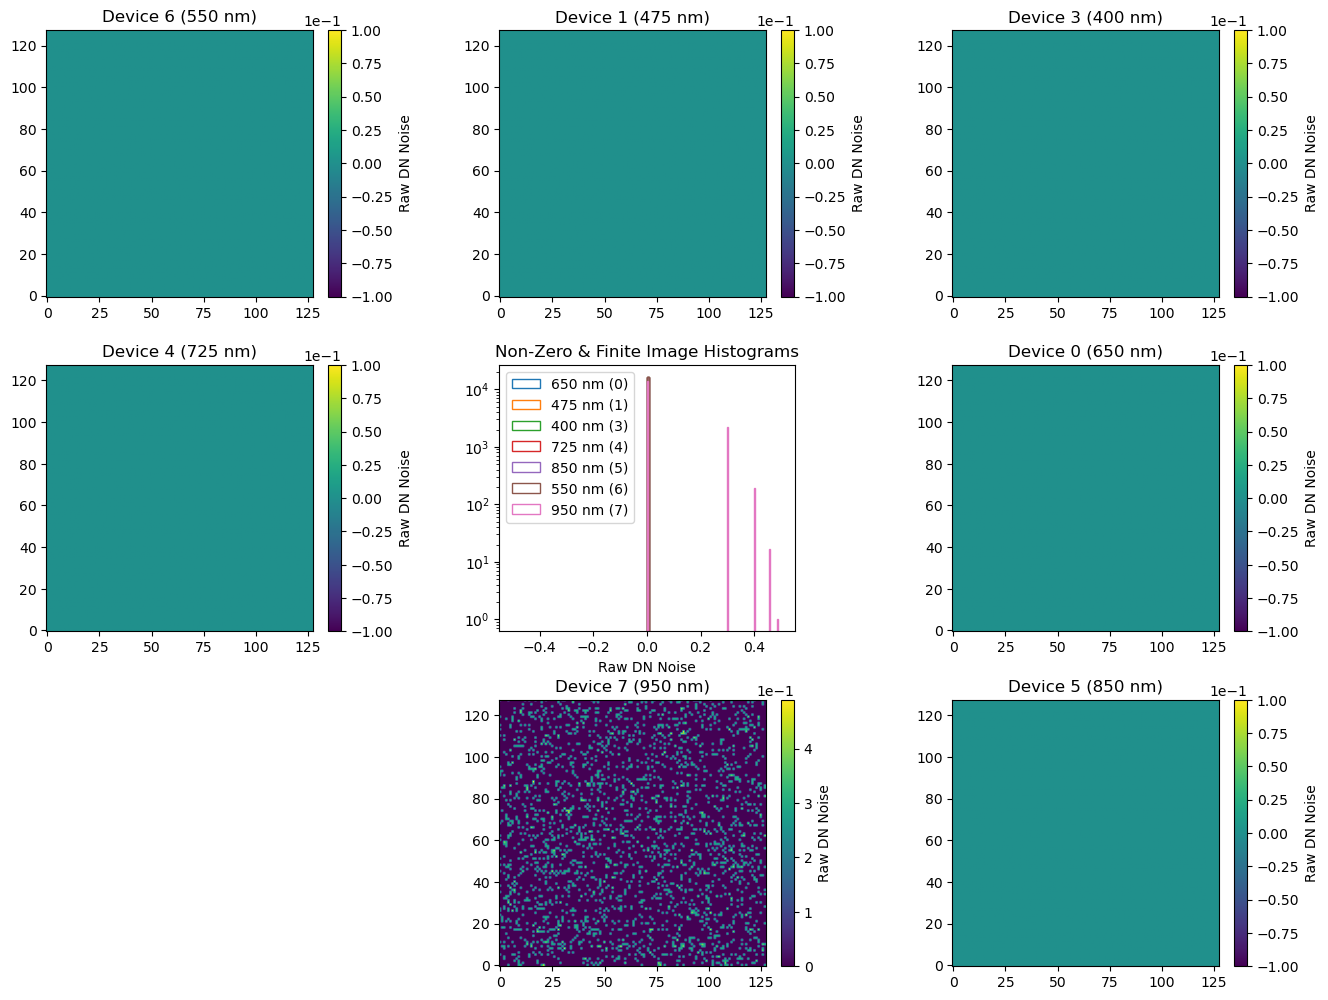

: 

In [85]:
osp.load_dark_frames('sample_1_r', roi=True)

We can see that once calibrated to reflectance, most channels have a peak reflectance in the region of ~5%, with fat and long-tailed distributions, with the birghtest pixels exhibitng up to 40% reflectance.

### Geometric Alignment

Now we apply the geometric alignment to the sample, to map all channels to the position of the 650 nm channel.

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:568: RuntimeWarning: invalid value encountered in subtract
  img = query_reg-train_img
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:575: RuntimeWarning: invalid value encountered in subtract
  img = np.abs(query_reg-train_img)/train_img
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:575: RuntimeWarning: divide by zero encountered in divide
  img = np.abs(query_reg-train_img)/train_img
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:575: RuntimeWarning: invalid value encountered in divide
  img = np.abs(query_reg-train_img)/train_img


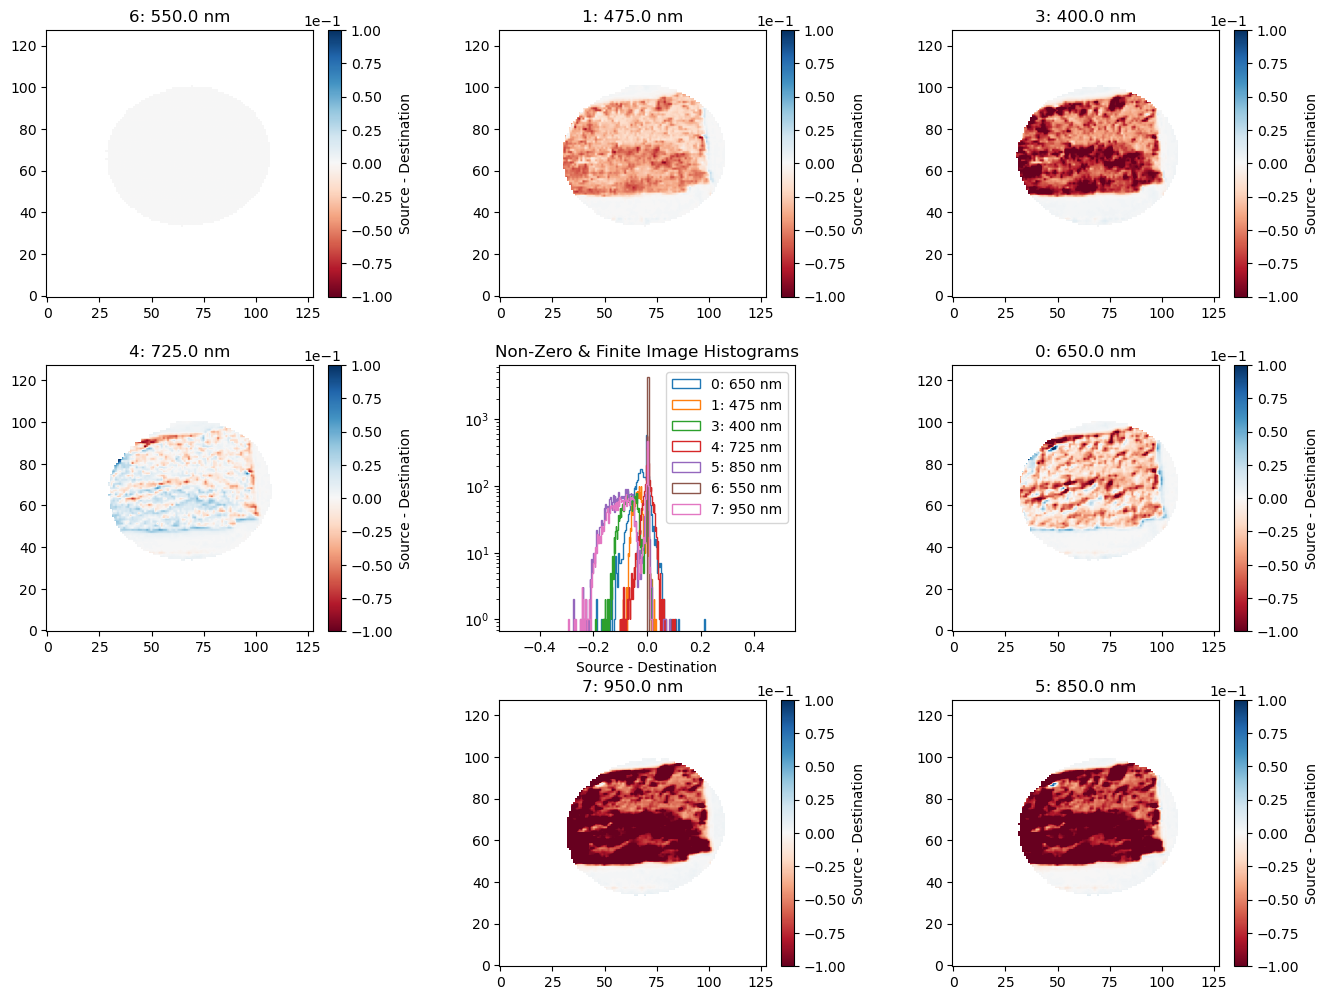

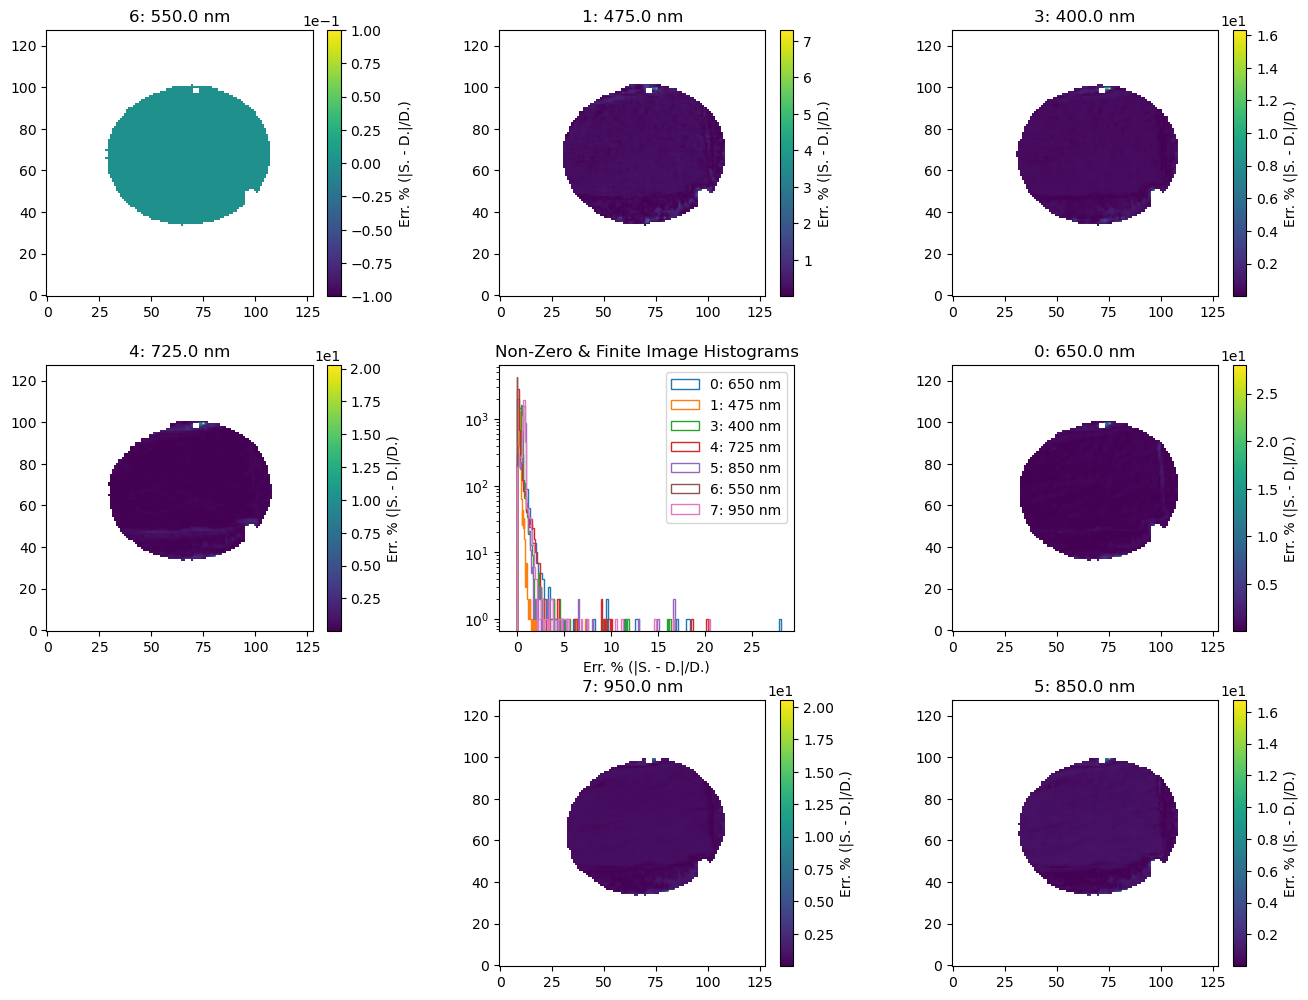

In [74]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

### Reflectance ROI Selection and Plotting

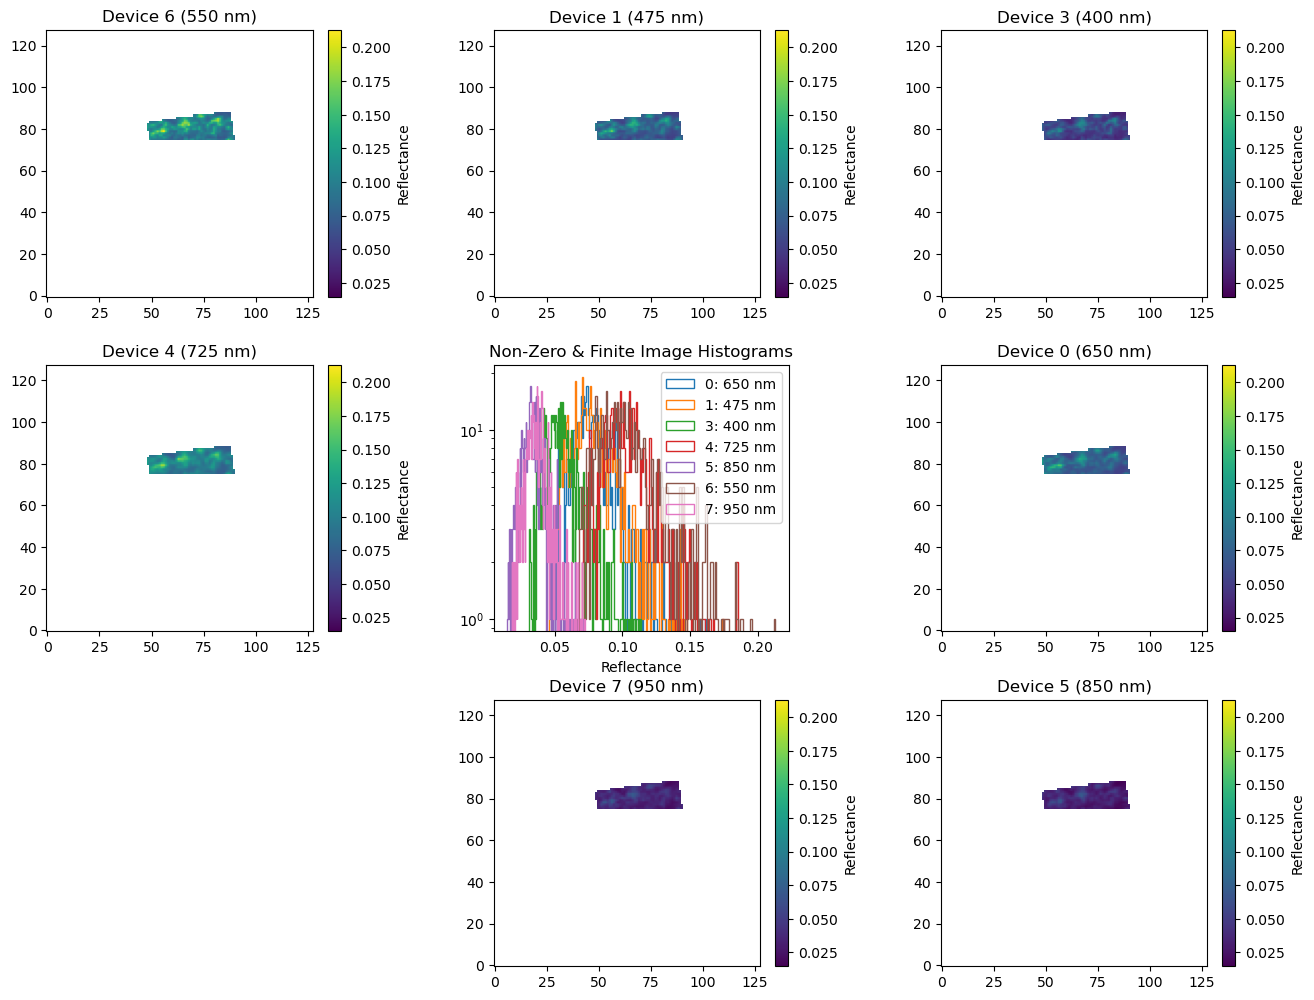

In [17]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

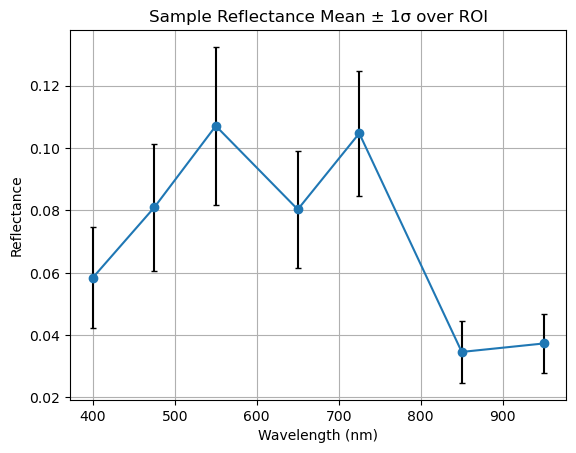

In [18]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:408: RuntimeWarning: divide by zero encountered in divide
  self.img_ave = self.img_ave / base.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:408: RuntimeWarning: invalid value encountered in divide
  self.img_ave = self.img_ave / base.img_ave
/Users/sci/Documents/projects/orochi_simulator_control/src/orochi_sim_proc.py:802: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


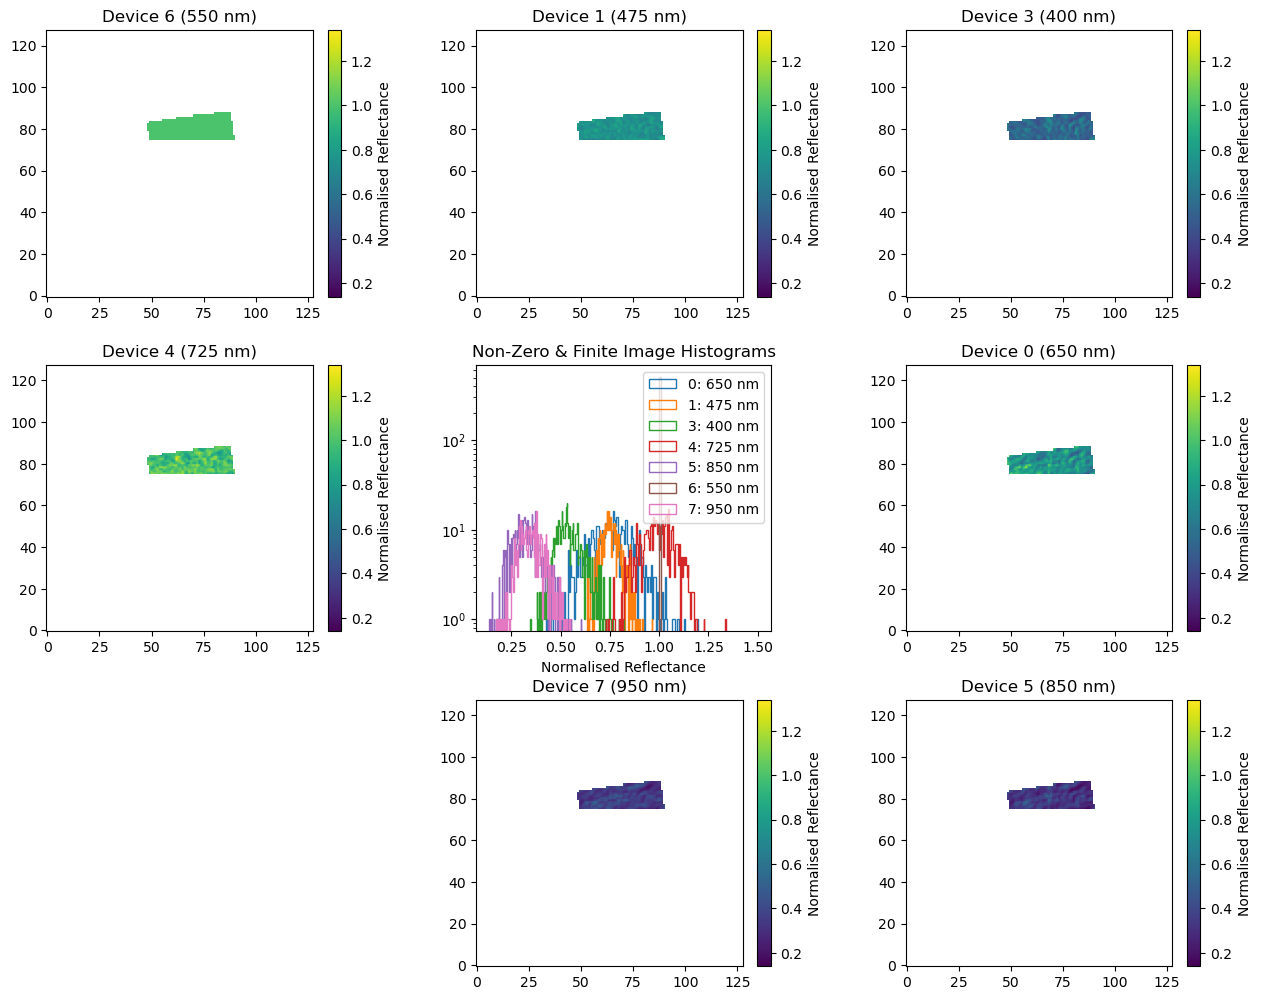

In [19]:
norm_refl = osp.normalise_reflectance(aligned_refl)

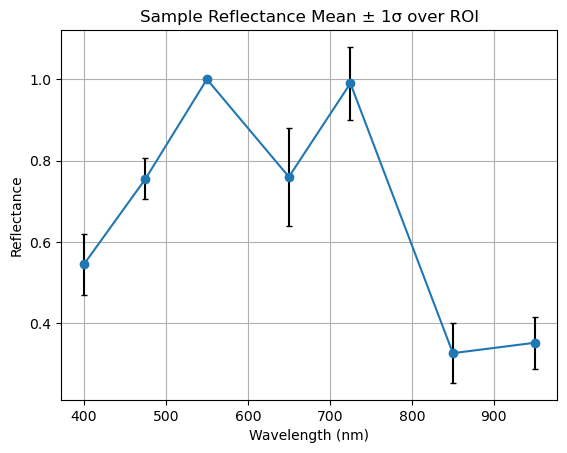

In [20]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

## Right

### Reflectance Calibration

In [ ]:
smpl_imgs = osp.load_sample('sample_1_r', roi=True)
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

### Geometric Alignment

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

### Reflectance ROI Selection and Plotting

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

# Sample 2

## Left

### Reflectance Calibration

In [ ]:
smpl_imgs = osp.load_sample('sample_2_r')
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

### Geometric Alignment

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

### Reflectance ROI Selection and Plotting

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

## Right

### Reflectance Calibration

In [ ]:
smpl_imgs = osp.load_sample('sample_2_r')
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

### Geometric Alignment

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

### Reflectance ROI Selection and Plotting

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

# Sample 3

## Left

### Reflectance Calibration

In [ ]:
smpl_imgs = osp.load_sample('sample_3_r')
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

### Geometric Alignment

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

### Reflectance ROI Selection and Plotting

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

## Right

### Reflectance Calibration

In [ ]:
smpl_imgs = osp.load_sample('sample_3_r')
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

### Geometric Alignment

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

### Reflectance ROI Selection and Plotting

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

# Sample 4

## Left

### Reflectance Calibration

In [ ]:
smpl_imgs = osp.load_sample('sample_4_r')
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

### Geometric Alignment

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

### Reflectance ROI Selection and Plotting

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

## Right

### Reflectance Calibration

In [ ]:
smpl_imgs = osp.load_sample('sample_4_r')
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

### Geometric Alignment

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

### Reflectance ROI Selection and Plotting

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

# Sample 5

## Left

### Reflectance Calibration

In [ ]:
smpl_imgs = osp.load_sample('sample_5_r')
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

### Geometric Alignment

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

### Reflectance ROI Selection and Plotting

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

## Right

### Reflectance Calibration

In [ ]:
smpl_imgs = osp.load_sample('sample_5_r')
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

### Geometric Alignment

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

### Reflectance ROI Selection and Plotting

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

# Checking the Dark and Light Reflectance Calibration After Imaging

In [ ]:
cali_imgs = osp.load_reflectance_calibration('reflectance_calibration')
cali_coeffs = osp.calibrate_reflectance(cali_imgs)

# Sample Reflectance Calibration and Coalignment
- Load, average and bias correct Sample images
- Correct for exposure
- Apply calibration coefficient frames
- Optional: mask for Calibration Target area and Sample area.
- Save reflectance images

## Checking against the 5% Spectralon Calibration Target - ERROR - Bad Exposures - need to repeat measurements for both first and second datasets

We expect the reflectance retrieved to be near 5%, with a slight positive gradient from short to long wavelengths.
This process will verify and validate the reflectance processing pipeline.

First we load the target images and perform bias correction.

In [ ]:
smpl_imgs = osp.load_sample('dark_reflectance_calibration_2')

Note that here we repeatedly find the images to contain negative value, implying the presence of random dark signal in these low-lighting images.

This is expected to a degree because of the longer exposure times required to image the low reflectance target. Note that we also expect the sample reflectance (i.e. rocks) to have reflectance in the range of ~5%, so this test is a goo dindicator of the noise we may expect.

We can also check if this dark noise is present over the region of interest:

In [ ]:
dark_smpl_imgs = osp.load_dark_frames('dark_reflectance_calibration', roi=True)

Indeed we see that for the 400 nm and 950 nm channels, there is noise, whereas all other channels have effectively 0 dark noise.
This is likely due to the exposure times required at these wavelengths, where the camera response is lowest.
Let's check the exposure times used:

In [ ]:
osp.get_exposures(dark_smpl_imgs)

Indeed we see that the exposures for the 400 and 950 nm channels are 840 ms and 1185 ms, whereas all other channels are < 30 ms.

Verifying that the exposures match...

In [ ]:
osp.get_exposures(smpl_imgs)

PROBLEM: the dark frame exposures do not match the light frame exposures. There as been an error here in the image capture!!!

This should be checked during image load in as standard.

In [ ]:
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)

## Checking against the dark calibration target

- expect to be near 0.1, but not exactly 0.1

In [ ]:
smpl_imgs = osp.load_sample('dark_reflectance_calibration_2')
reflectance = osp.apply_reflectance_calibration(smpl_imgs, cali_coeffs)

In [ ]:
aligned_refl = osp.apply_coalignment(reflectance, coals)

In [ ]:
aligned_refl_rois = osp.set_roi(aligned_refl, base_channel='6_550')

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=aligned_refl_rois)

In [ ]:
norm_refl = osp.normalise_reflectance(aligned_refl)

In [ ]:
results = osp.plot_roi_reflectance(refl_imgs=norm_refl)